Задание 4. PCA, tSNE, UMAP, PacMAP

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import umap
import pacmap

[1] Сгенерировать и визуализировать на парах признаков 5-мерный датасет df из 1000
точек, в котором отдельные точки данных расположены вдоль линии с началом
(0,0,0,0,0) и завершением (+A,+A,+A,+A,+A) с дисперсиями вдоль осей: для оси 1 = A/k,
для оси 2 = A/k, для оси 3 = A/(k*2), для оси 4 = A/(k*4), для оси 5 = A/(k*8), где k может
быть в диапазоне от 4 до 40.

5D датасет вдоль линии (0,0,0,0,0) - (A,A,A,A,A) с шумом дисперсии/сигмы вдоль осей
- A/k
- A/k
- A/(k*2)
- A/(k*4)
- A/(k*8)

<br>Здесь используем эти значения как стандартное отклонение


In [20]:
n_per_class=1000
A=10.0
k=10.0
random_state=0

In [21]:
rng = np.random.RandomState(random_state)
t = rng.rand(n_per_class, 1)  # параметр вдоль линии [0,1]
base = t * A
X = np.repeat(base, 5, axis=1)

sigmas = np.array([A / k, A / k, A / (k * 2),
                       A / (k * 4), A / (k * 8)], dtype=float)
noise = rng.normal(scale=sigmas, size=X.shape)
X_noisy = X + noise

cols = [f'x{i}' for i in range(1, 6)]
df = pd.DataFrame(X_noisy, columns=cols)

In [22]:
df.describe()

x1           x2           x3           x4           x5
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000
mean      5.011951     4.952385     4.949399     4.954031     4.954244
std       3.044380     3.157699     2.943888     2.903878     2.912785
min      -2.190777    -1.788634    -0.573075    -0.301909    -0.171199
25%       2.545414     2.282100     2.484938     2.581269     2.489755
50%       5.054763     4.873412     4.738575     4.881378     4.754211
75%       7.523695     7.614140     7.521569     7.463815     7.375697
max      12.523963    12.468528    10.610804    10.192936    10.168606

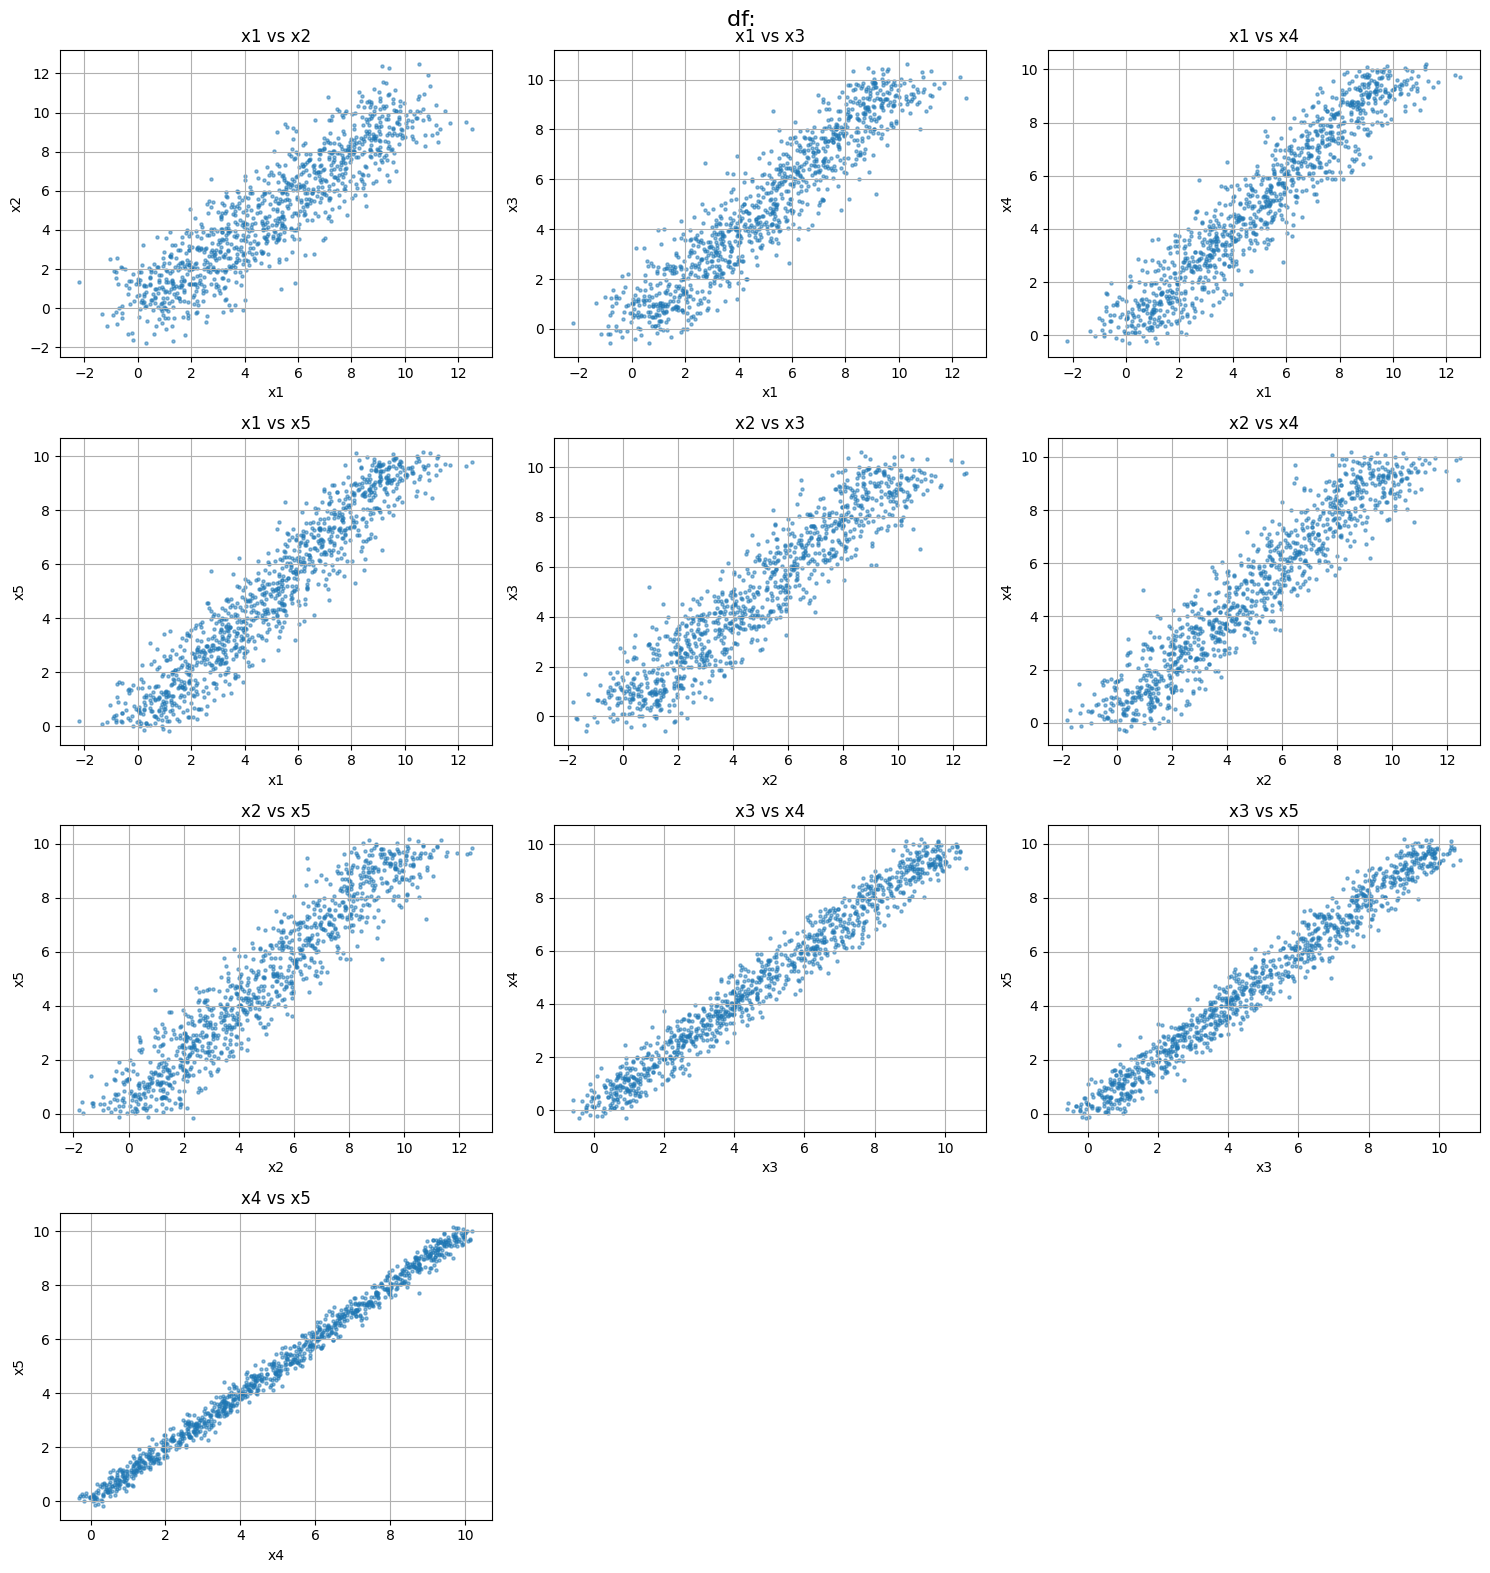

In [23]:
def plot_feature_pairs_single_figure(df, features, hue=None, title=''):
    # все пары признаков в одной subplot grid

    pairs = list(combinations(features, 2))
    n = len(pairs)

    # размеры сетки
    cols = 3
    rows = int(np.ceil(n / cols))

    plt.figure(figsize=(5 * cols, 4 * rows))

    for idx, (x_col, y_col) in enumerate(pairs, start=1):
        plt.subplot(rows, cols, idx)

        if hue is None:
            plt.scatter(df[x_col], df[y_col], s=5, alpha=0.5)
        else:
            for cls in sorted(df[hue].unique()):
                subset = df[df[hue] == cls]
                plt.scatter(subset[x_col], subset[y_col],
                            s=5, alpha=0.6, label=str(cls))
                
            if idx == 1:
                plt.legend(loc='best')

        plt.xlabel(x_col)
        plt.ylabel(y_col)
        plt.title(f'{x_col} vs {y_col}')
        plt.grid(True)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


plot_feature_pairs_single_figure(df, df.columns, title='df: ')

[2] На основе датасета df cгенерировать и визуализировать на парах признаков 5-
мерные датасеты df
out
_
_
i, в которых помимо точек датасета df есть дополнительные
1000 точек с координатой (+A*i,
- A*i,+ A*i,
- A*i,+ A*i) при i = 1, 2, 5, 10.

Добавляем 1000 точек с координатой
- (+A*i, -A*i, +A*i, -A*i, +A*i)

In [24]:
def make_outlier_dataset(df_base, A, i, n_out=1000):
    df = df_base.copy()
    df['is_outlier'] = 0

    outlier_point = np.array([A * i, -A * i, A * i, -A * i, A * i])
    outliers = np.tile(outlier_point, (n_out, 1))
    outliers_df = pd.DataFrame(outliers, columns=df_base.columns)
    outliers_df['is_outlier'] = 1

    df_out = pd.concat([df, outliers_df], ignore_index=True)
    return df_out

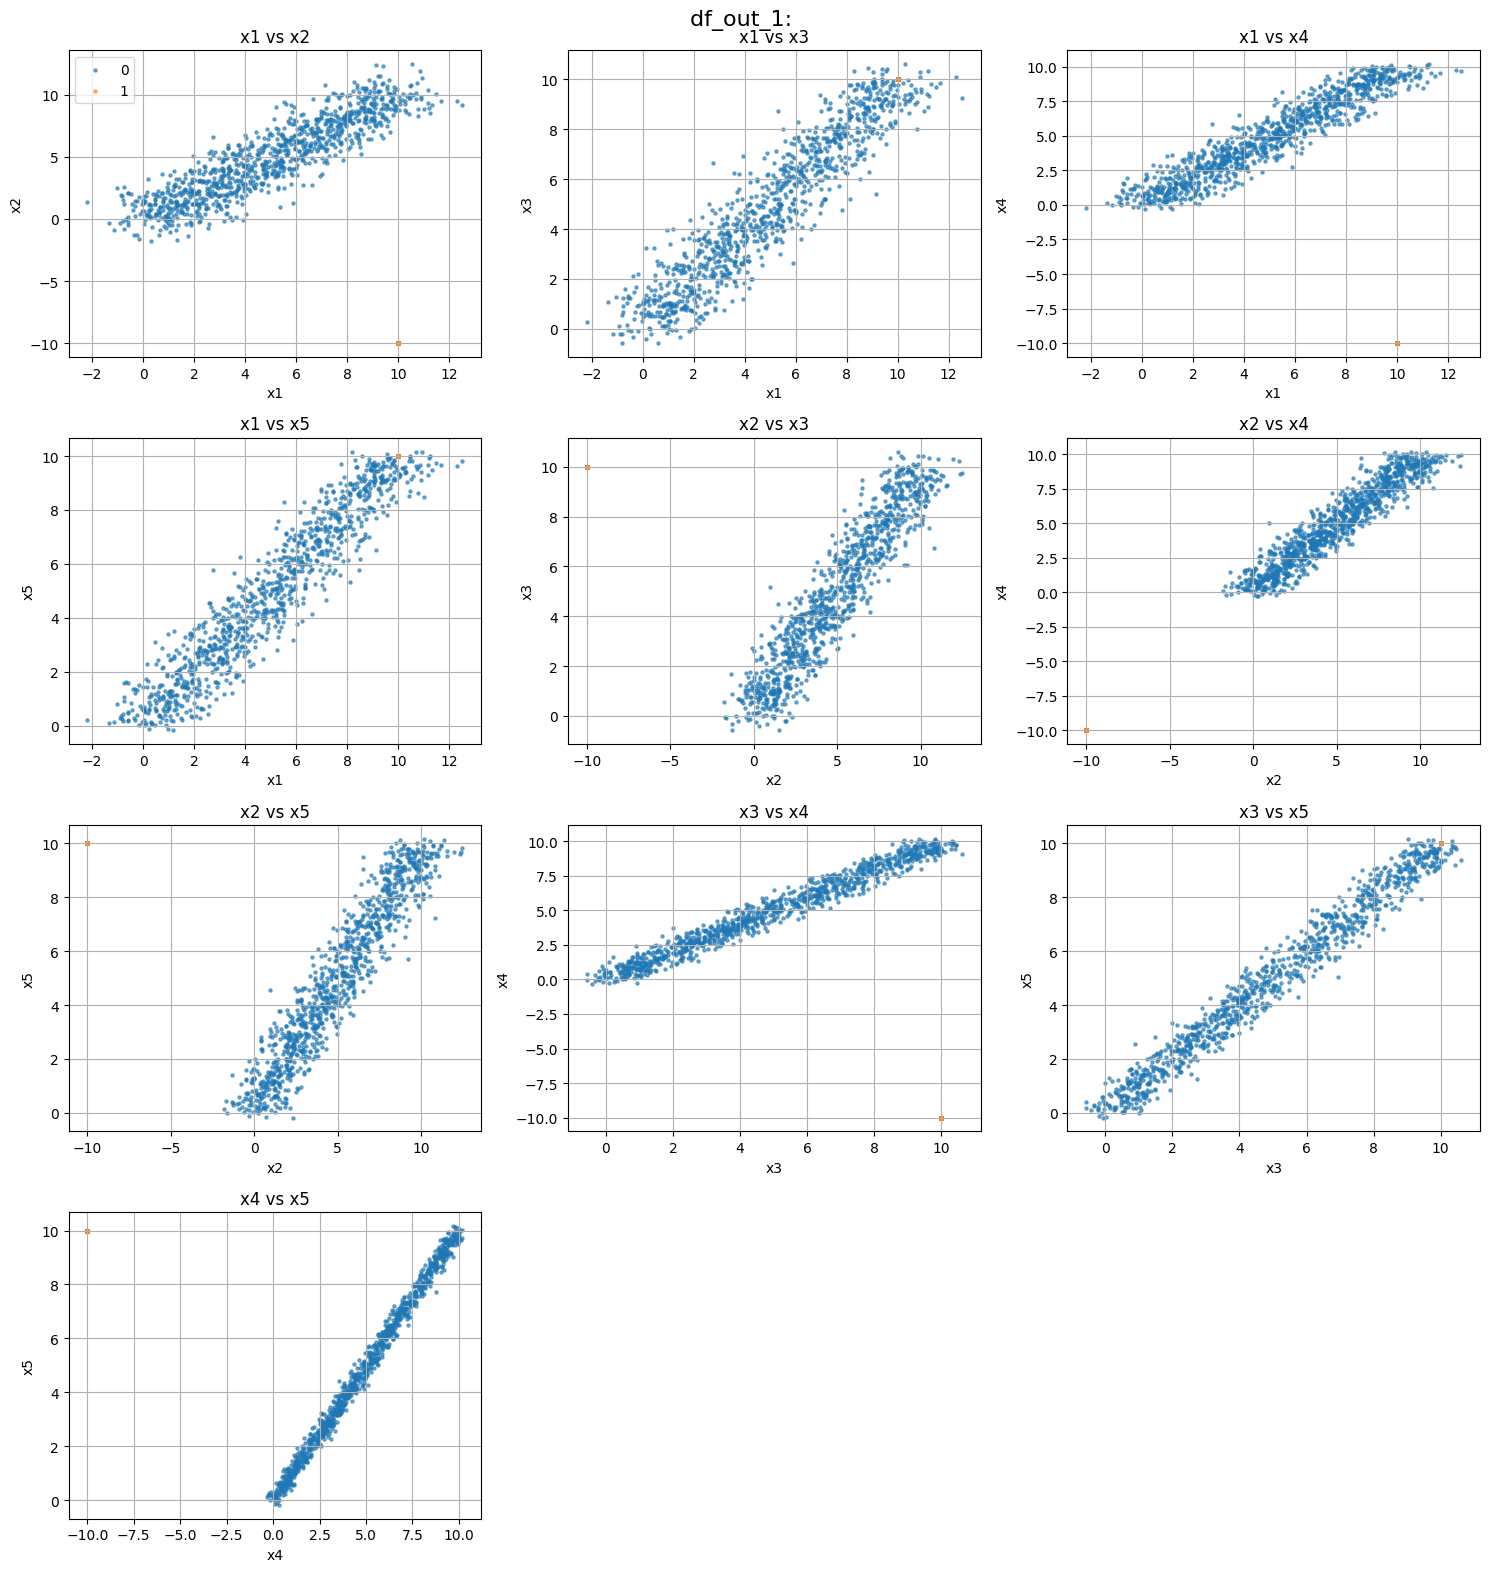

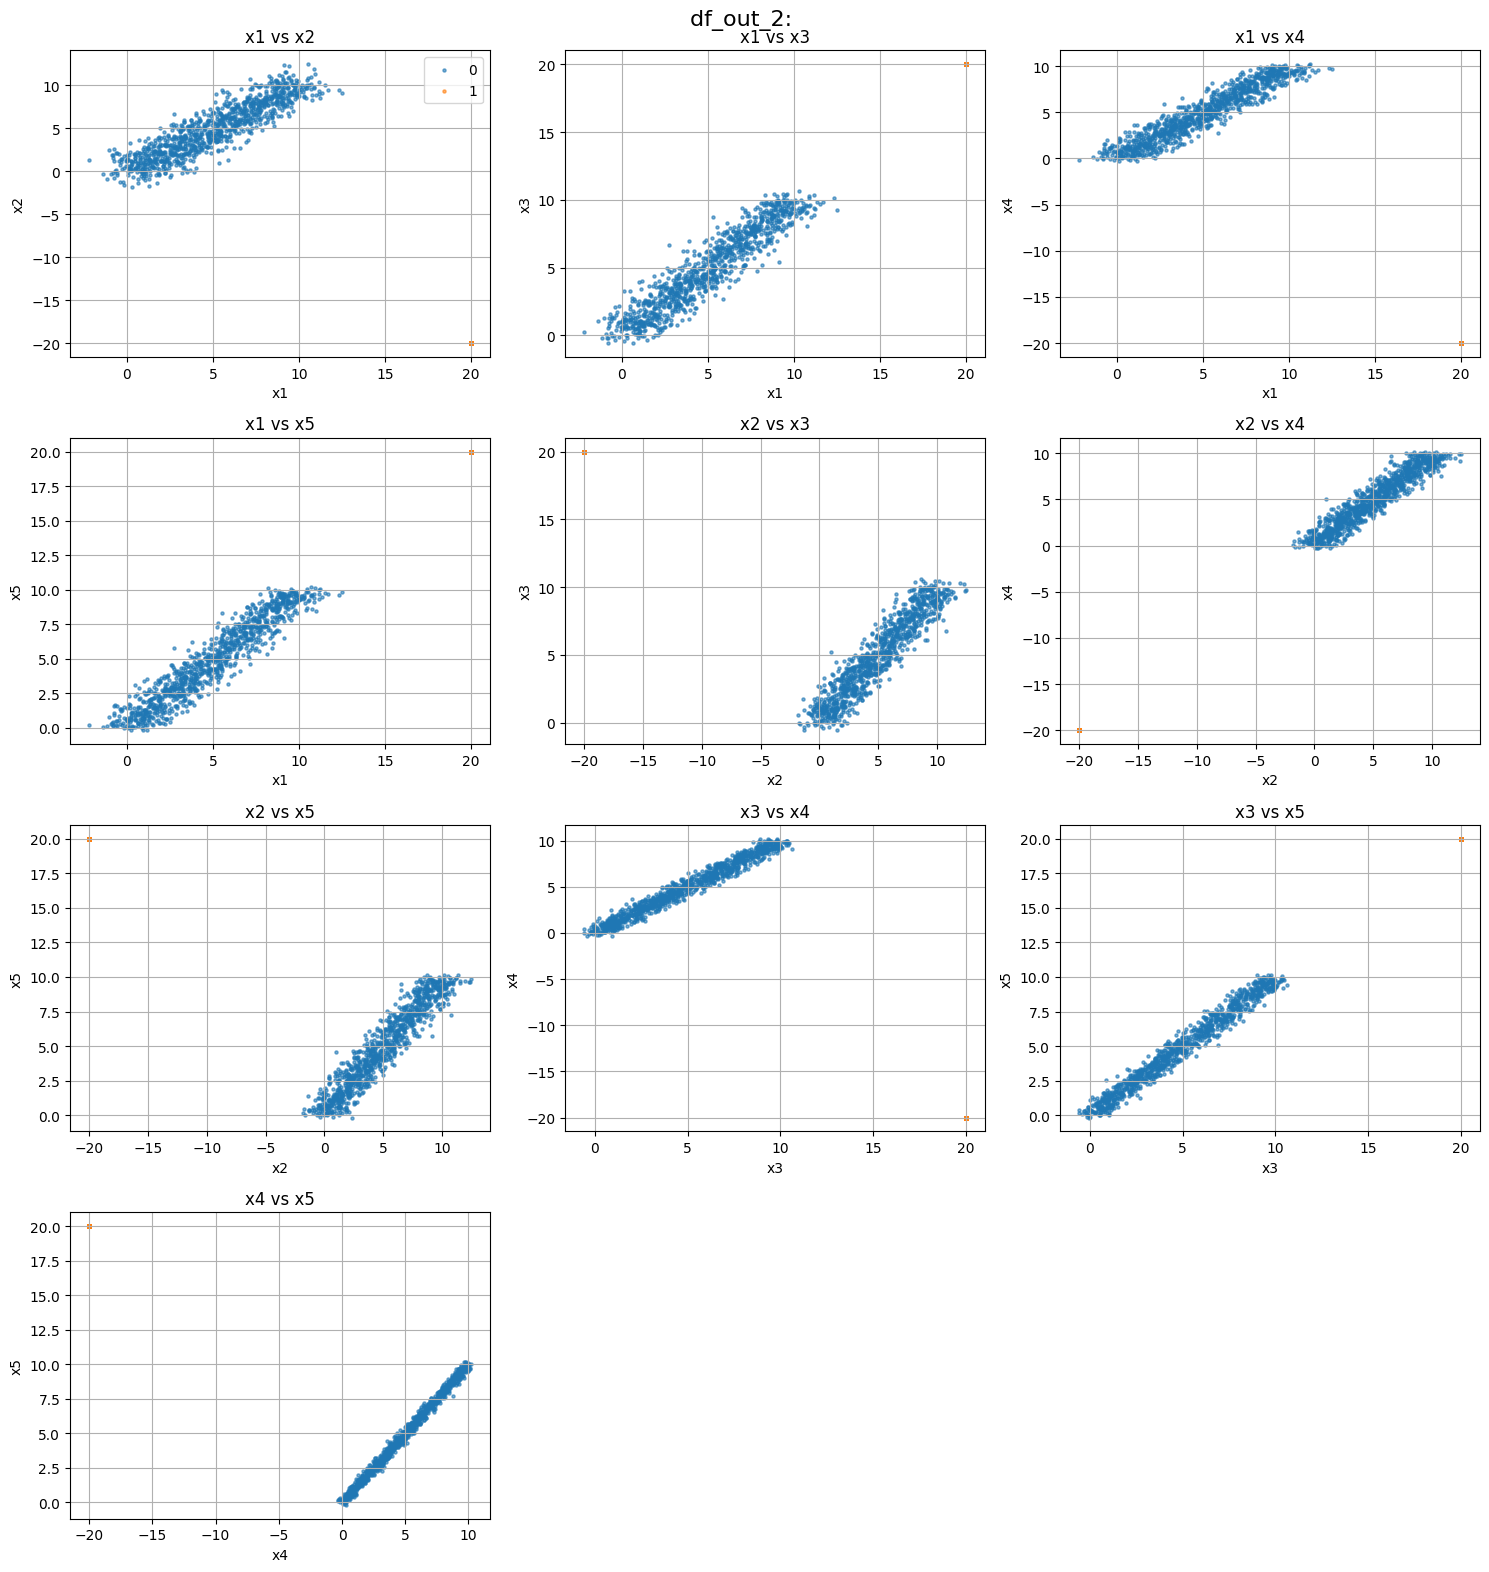

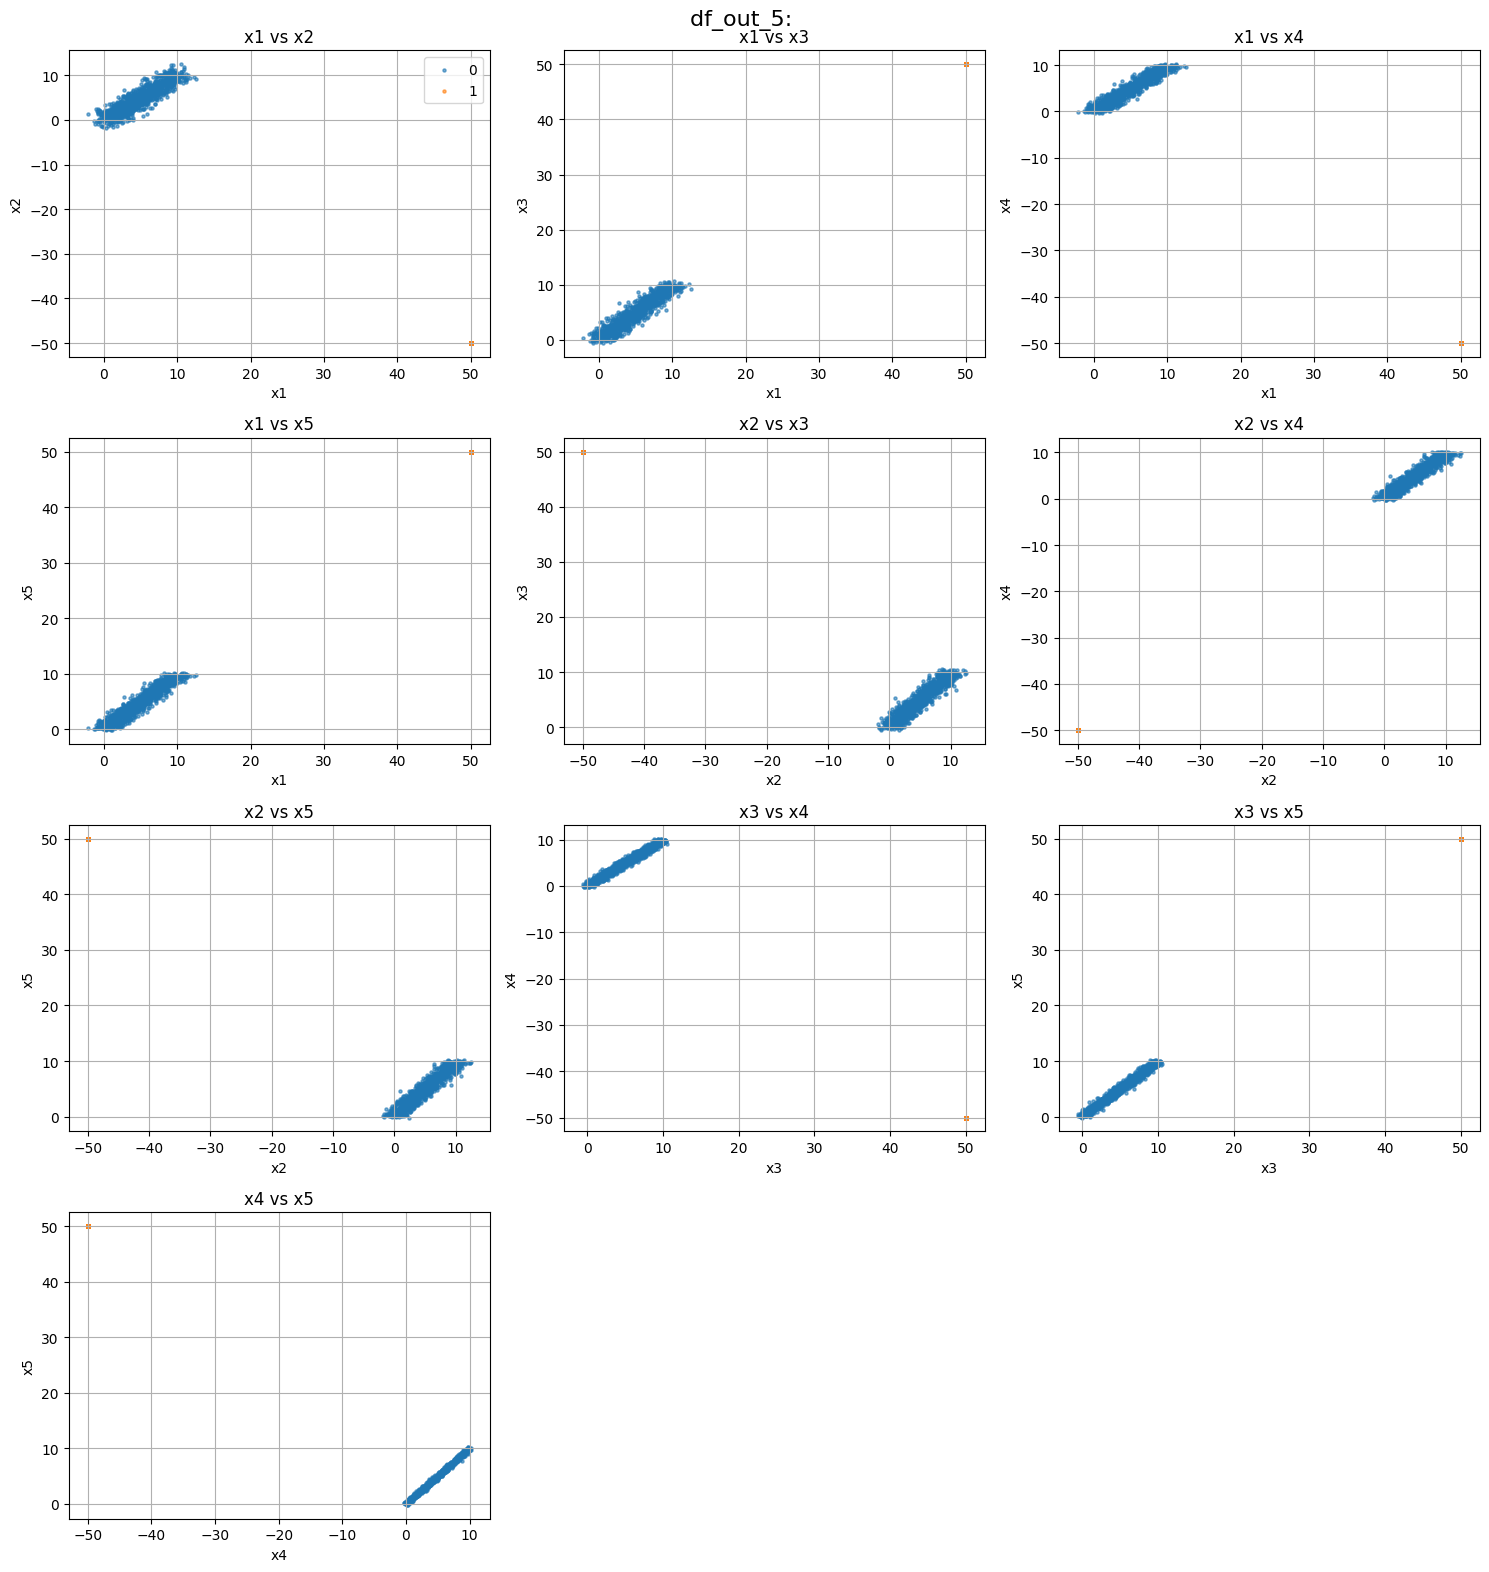

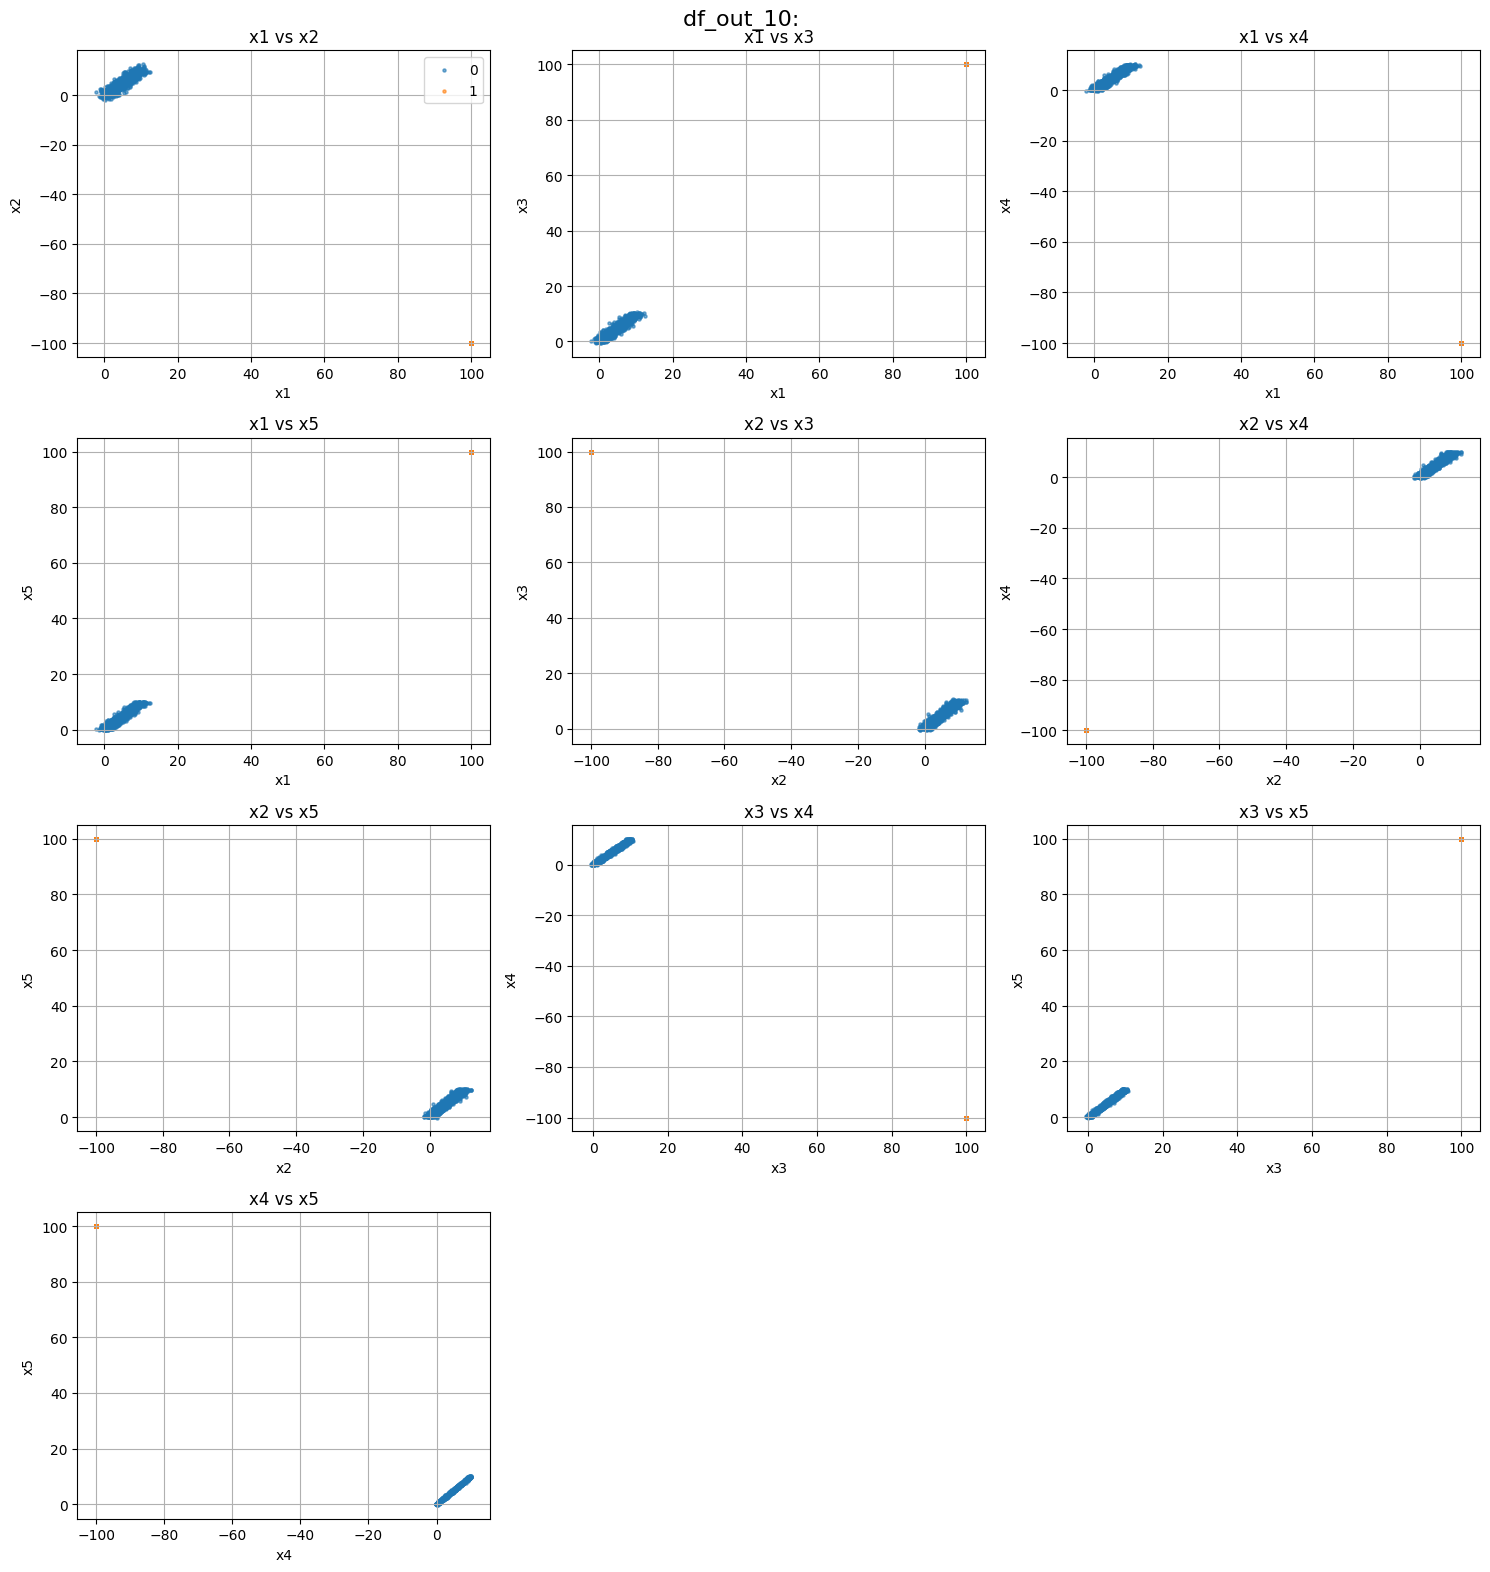

In [25]:
dfs_out = {}
for i in [1, 2, 5, 10]:
    df_out_i = make_outlier_dataset(df, A=A, i=i, n_out=1000)
    dfs_out[i] = df_out_i
    plot_feature_pairs_single_figure(df_out_i, df.columns,
                        hue='is_outlier',
                        title=f'df_out_{i}: ')

[3] Используя метод главных компонент (основанный на корреляциях), для каждого
датасета (df и df
out
_
_
i) отдельно визуализировать:
- Scree plot;
- Отображения отдельных объектов-строк в двумерных пространствах всех пар главных
компонент, без отображения старых векторов-переменных;
- Отображения отдельных объектов-строк в двумерных пространствах всех пар главных
компонент, с отображением старых векторов-переменных;
- Отображения степени корреляции старых векторов-переменных с новыми векторами-
переменными в двумерных пространствах всех пар главных компонет.

In [26]:
def pca_full_analysis(
    df,
    feature_cols,
    dataset_name='dataset',
    standardize=True,
    max_components_to_plot=None,
    figsize=(20, 20)
):
    # полный PCA-анализ показывает. Scree plot, Scatter на всех парах ГК, Biplot на тех же парах, корреляционный круг на тех же парах

    # Стандартизация
    X = df[feature_cols].values
    if standardize:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = X

    # PCA
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)

    n_components = X_pca.shape[1]
    if max_components_to_plot is None:
        comp_indices = list(range(n_components))
    else:
        comp_indices = list(range(min(max_components_to_plot, n_components)))

    # все пары компонент
    pairs = list(combinations(comp_indices, 2))

    # сколько всего графиков
    # 1 (scree) + 3 * число пар компонент
    total_plots = 1 + 3 * len(pairs)

    cols = 3
    rows = int(np.ceil(total_plots / cols))

    fig = plt.figure(figsize=figsize)
    fig.suptitle(f'PCA Анализ: {dataset_name}', fontsize=18)

    plot_idx = 1

    # Scree plot 
    ax = fig.add_subplot(rows, cols, plot_idx)
    plot_idx += 1
    ax.plot(range(1, n_components + 1),
            pca.explained_variance_ratio_, 'o-')
    ax.set_title('Scree plot')
    ax.set_xlabel('Компонента')
    ax.set_ylabel('Доля дисперсии')
    ax.grid(True)

    # Корреляции переменных с ПК
    corr = np.corrcoef(X_scaled.T, X_pca.T)[:len(feature_cols),
                                            len(feature_cols):]

    # Для каждой пары компонент рисуем 3 графика
    for a, b in pairs:

        # Scatter объектов
        ax = fig.add_subplot(rows, cols, plot_idx)
        plot_idx += 1
        ax.scatter(X_pca[:, a], X_pca[:, b], s=10, alpha=0.5)
        ax.set_title(f'Scatter PC{a+1} vs PC{b+1}')
        ax.set_xlabel(f'PC{a+1}')
        ax.set_ylabel(f'PC{b+1}')
        ax.axhline(0, color='grey', linewidth=0.5)
        ax.axvline(0, color='grey', linewidth=0.5)
        ax.grid(True)

        # Biplot
        ax = fig.add_subplot(rows, cols, plot_idx)
        plot_idx += 1
        ax.scatter(X_pca[:, a], X_pca[:, b], s=10, alpha=0.3)

        max_x = np.max(np.abs(X_pca[:, a]))
        max_y = np.max(np.abs(X_pca[:, b]))

        for i, feat in enumerate(feature_cols):
            vx = corr[i, a] * max_x
            vy = corr[i, b] * max_y
            ax.arrow(0, 0, vx, vy, head_width=0.05 * max_x,
                     color='red', length_includes_head=True)
            ax.text(vx * 1.05, vy * 1.05, feat, color='red')

        ax.set_title(f'Biplot PC{a+1} vs PC{b+1}')
        ax.axhline(0, color='grey', linewidth=0.5)
        ax.axvline(0, color='grey', linewidth=0.5)
        ax.grid(True)

        # Корреляционный круг
        ax = fig.add_subplot(rows, cols, plot_idx)
        plot_idx += 1

        circle = plt.Circle((0, 0), 1, fill=False, color='lightgray')
        ax.add_artist(circle)

        for i, feat in enumerate(feature_cols):
            x = corr[i, a]
            y = corr[i, b]
            ax.arrow(0, 0, x, y, head_width=0.03,
                     length_includes_head=True, color='blue')
            ax.text(x * 1.05, y * 1.05, feat, color='blue')

        ax.set_title(f'Corr circle PC{a+1} vs PC{b+1}')
        ax.axhline(0, color='grey', linewidth=0.5)
        ax.axvline(0, color='grey', linewidth=0.5)
        ax.set_xlim(-1.1, 1.1)
        ax.set_ylim(-1.1, 1.1)
        ax.set_aspect('equal', 'box')
        ax.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

    return pca, X_scaled, X_pca, corr

PCA для df


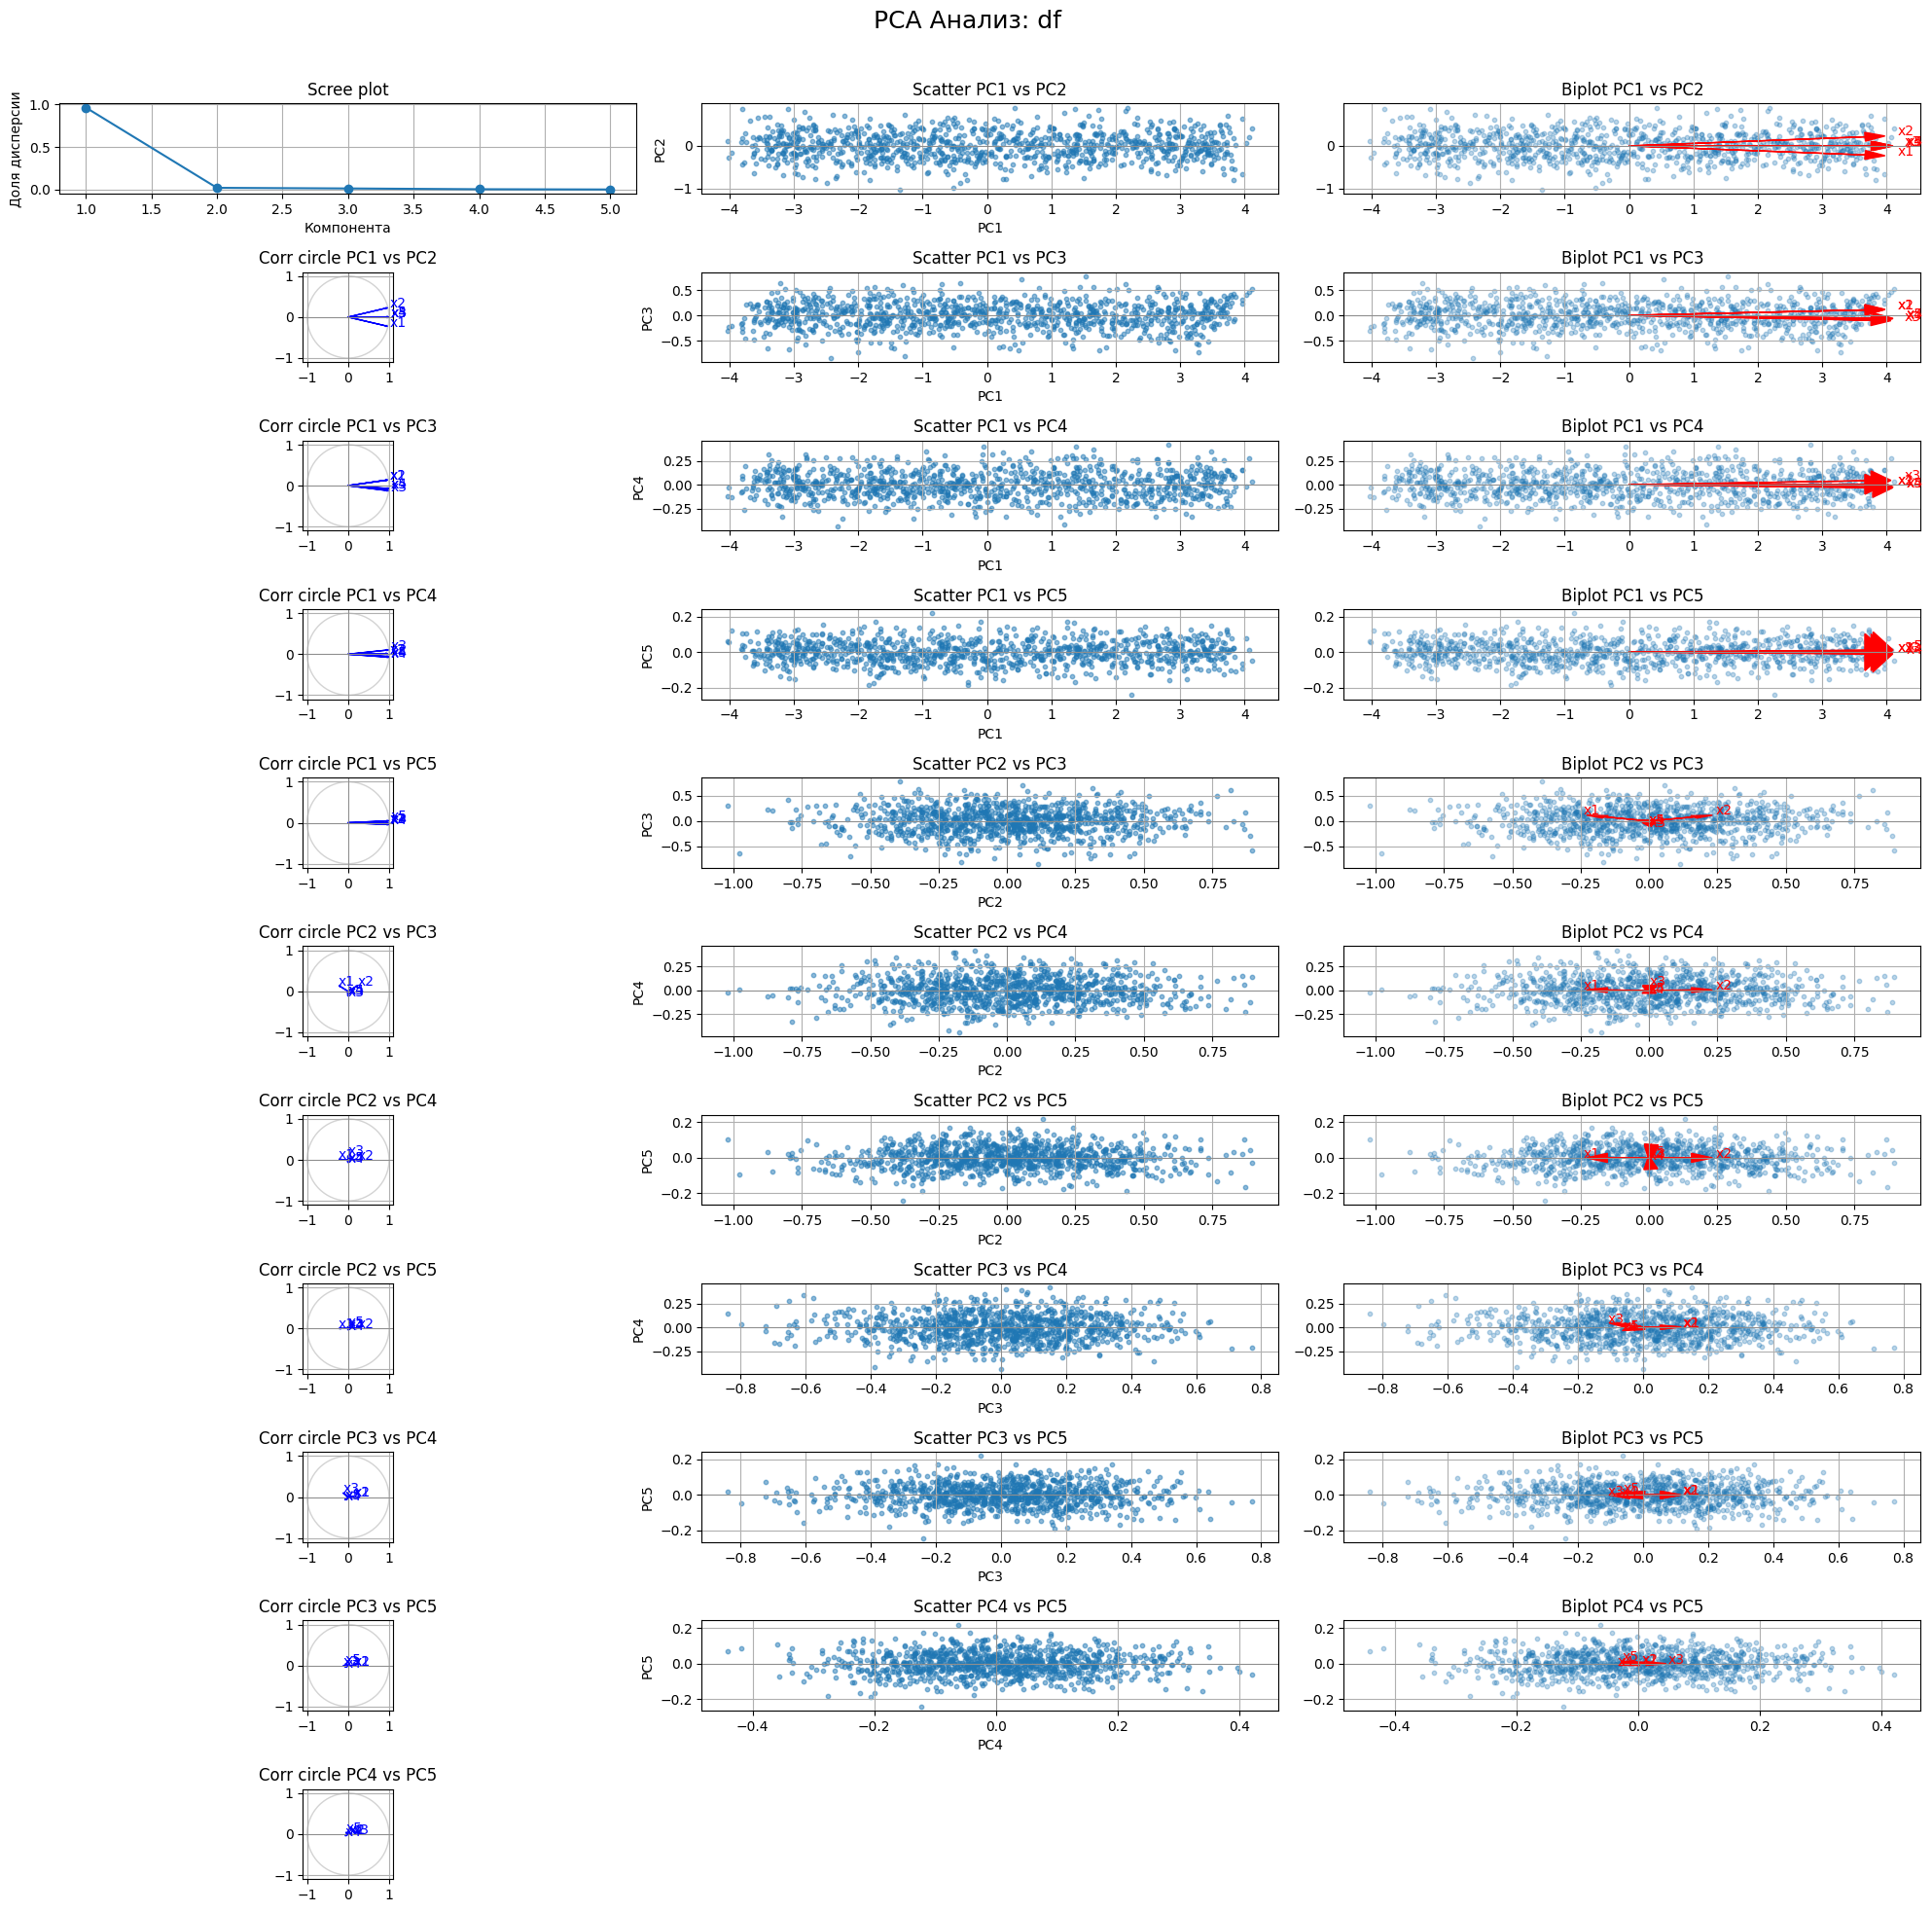

PCA для df_out_1


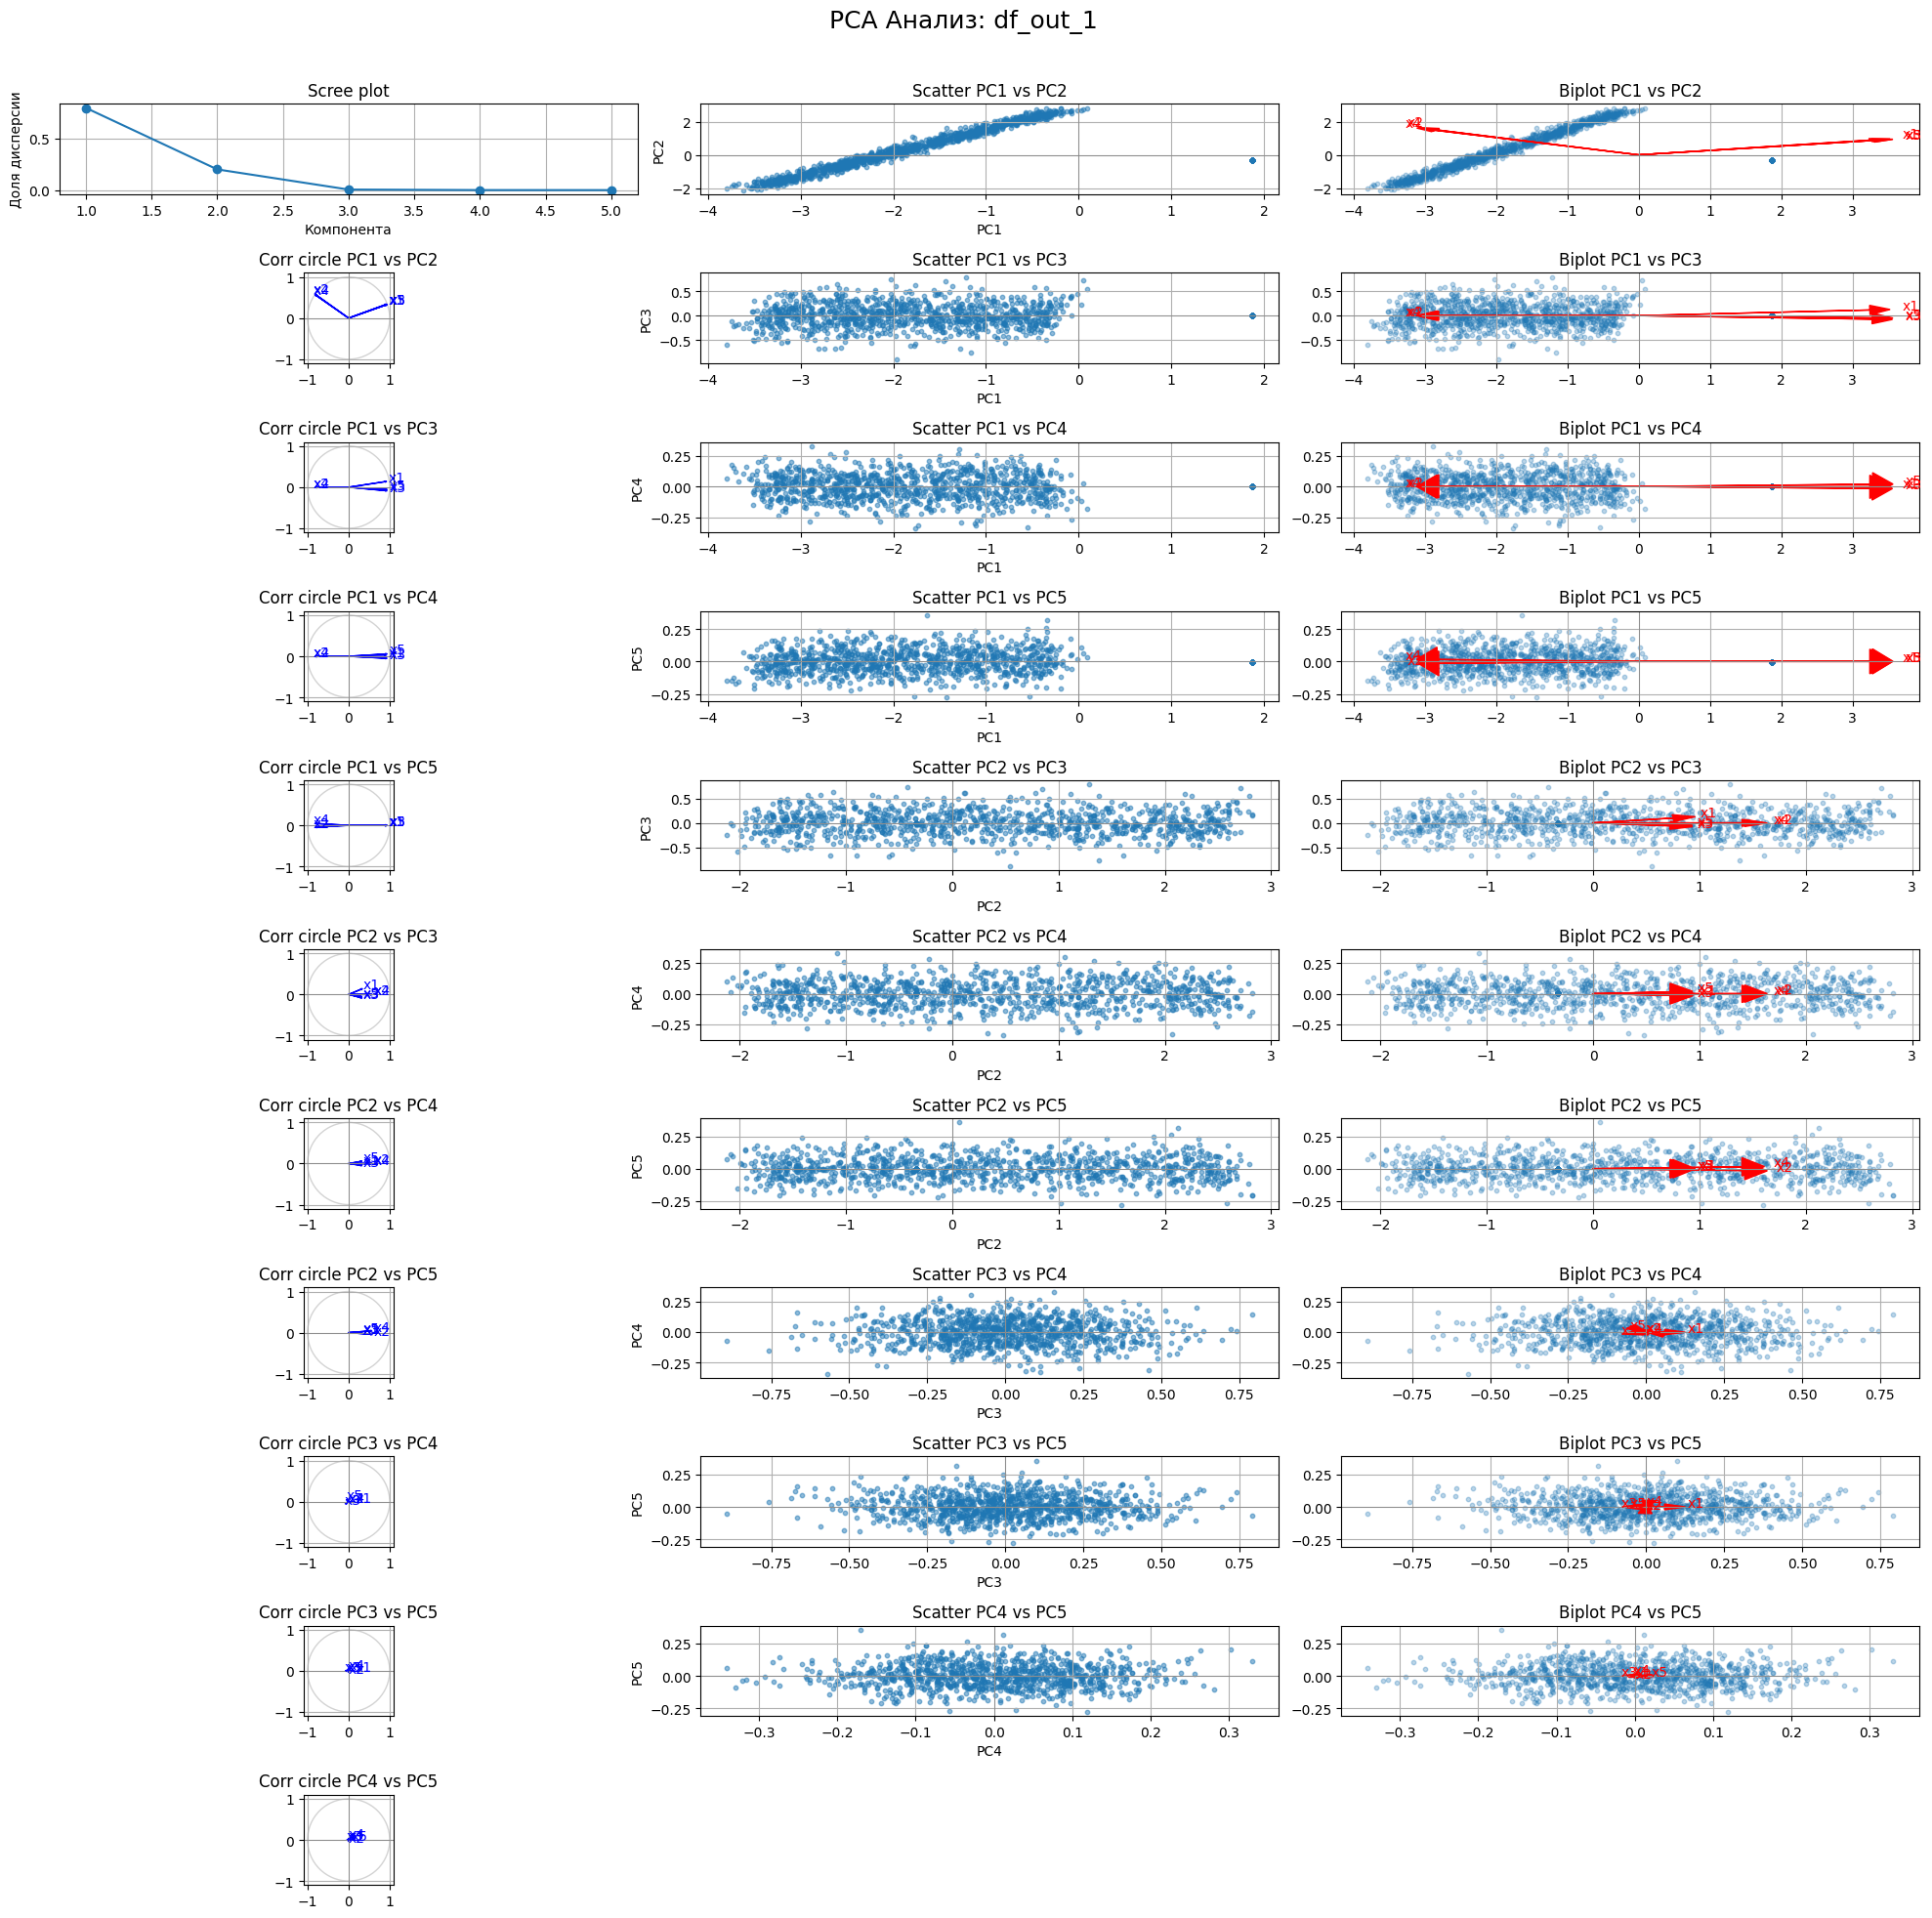

PCA для df_out_2


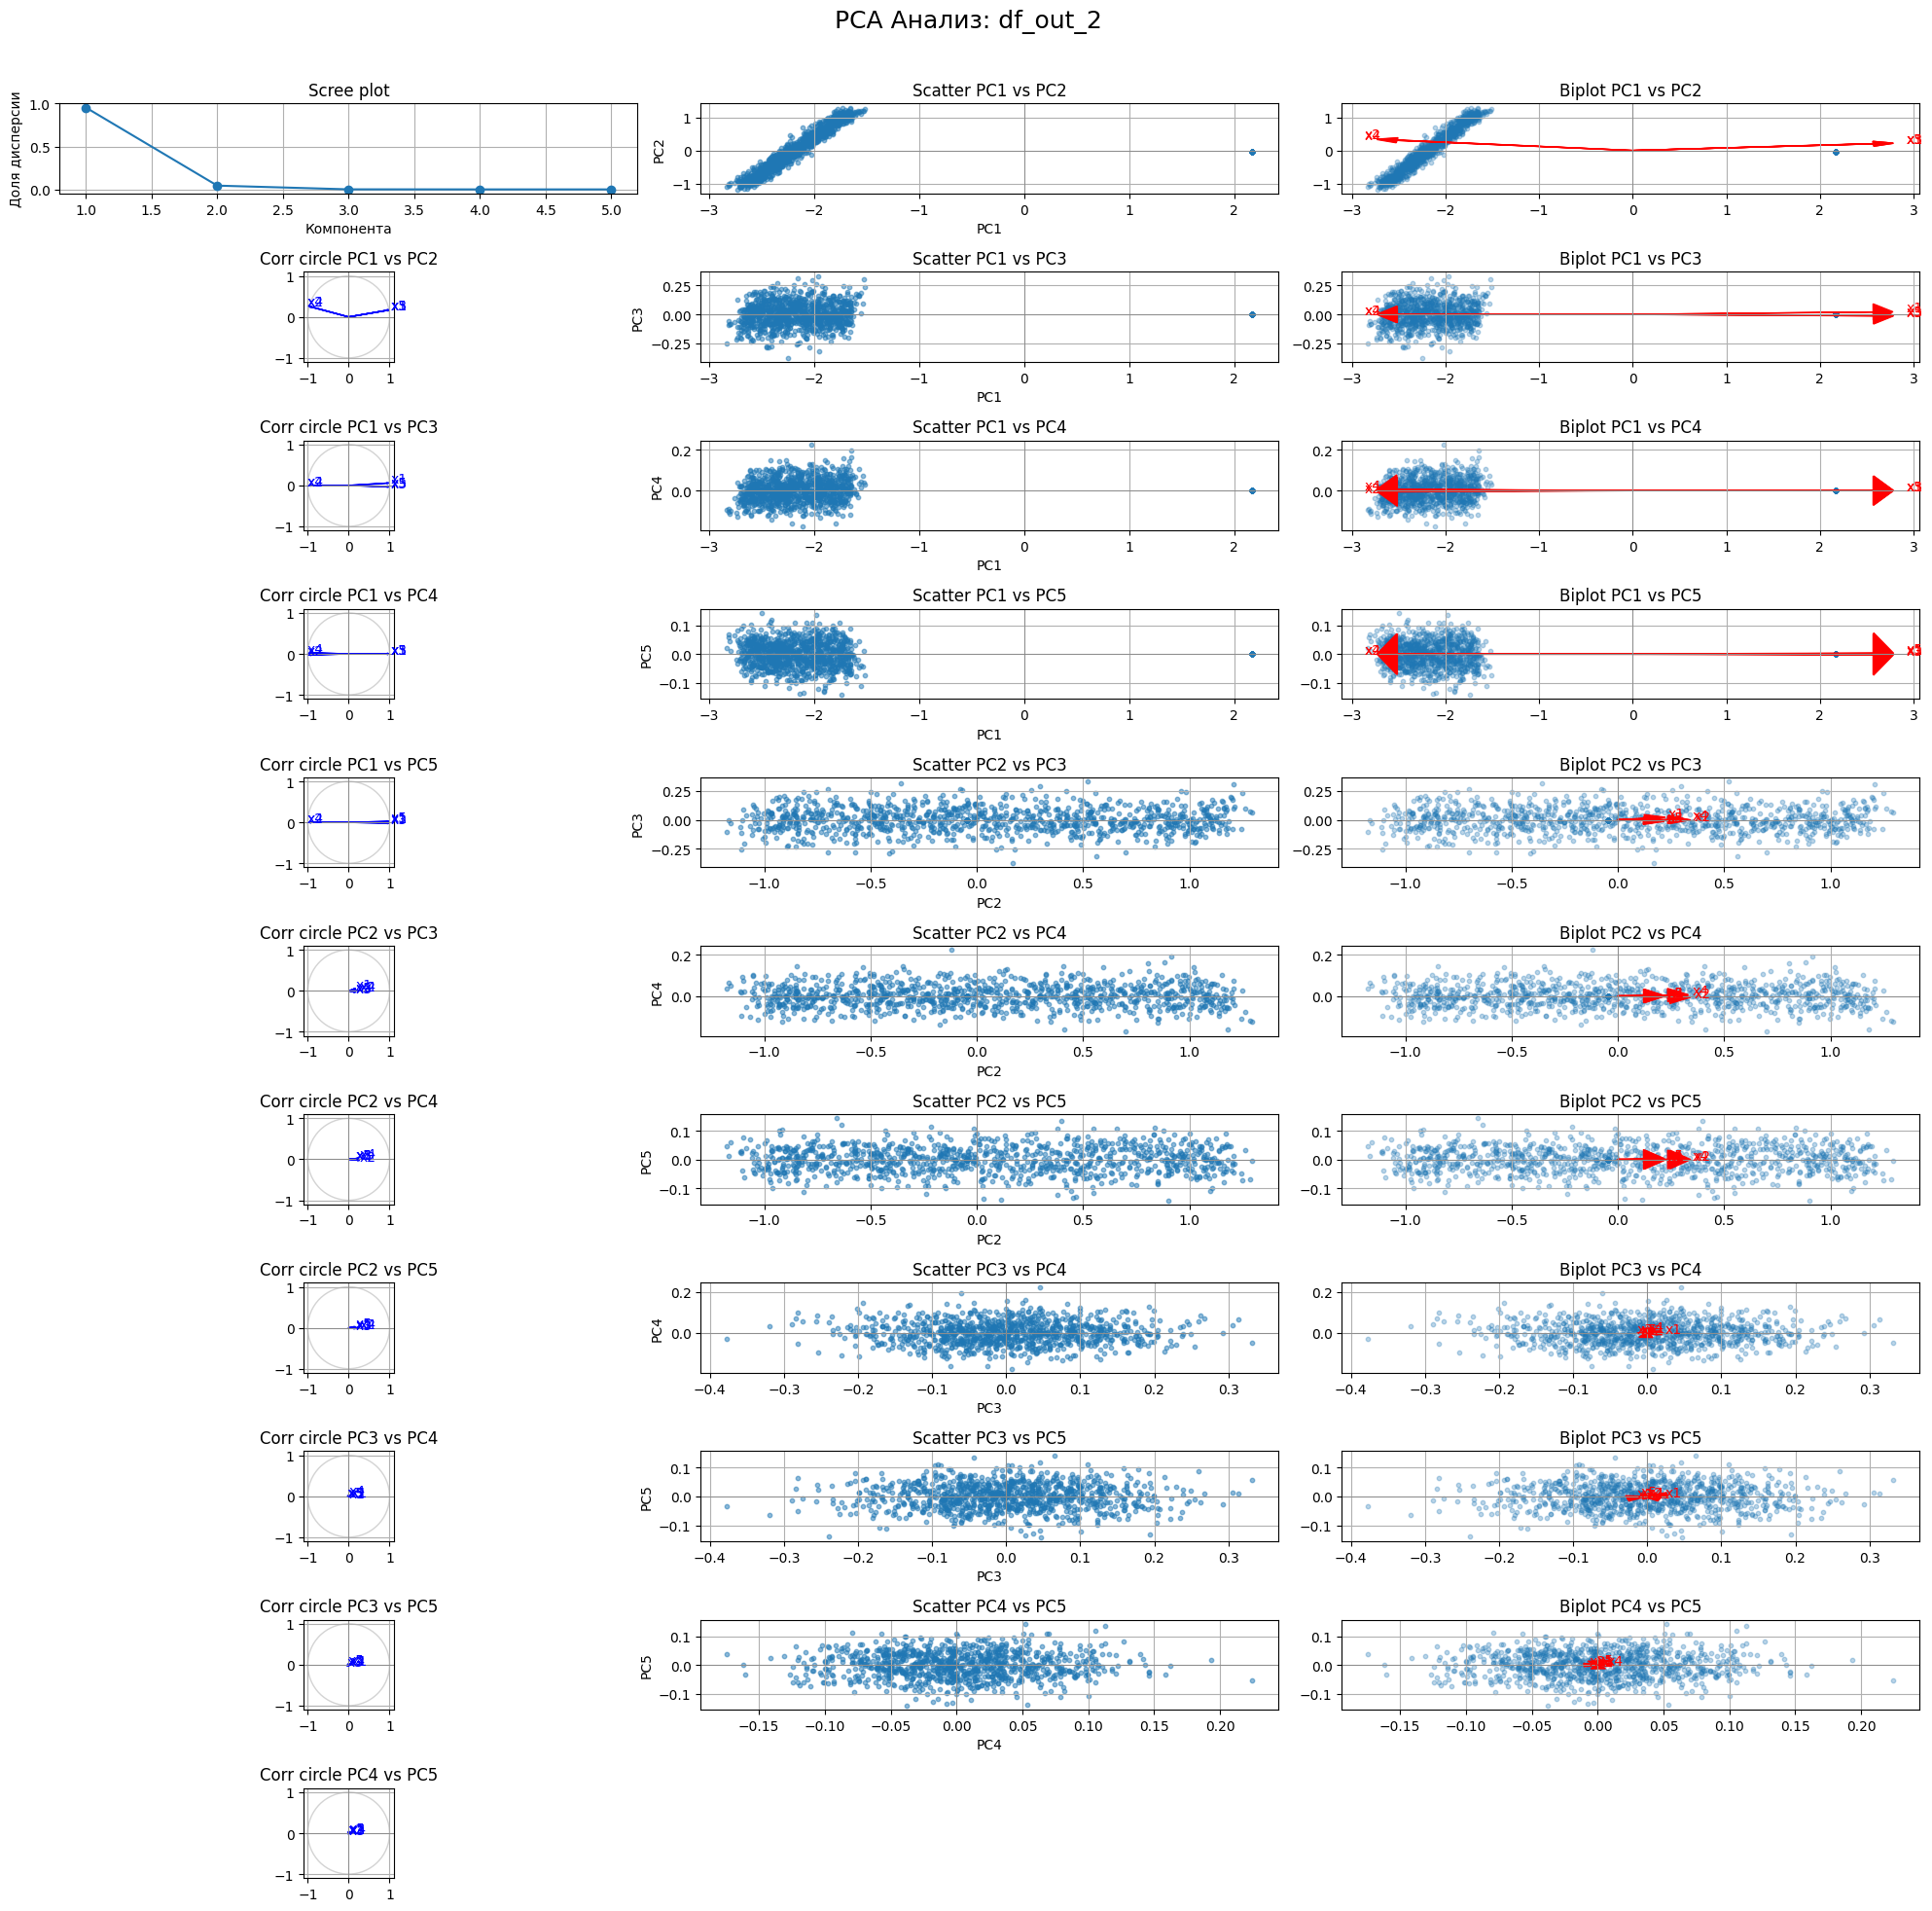

PCA для df_out_5


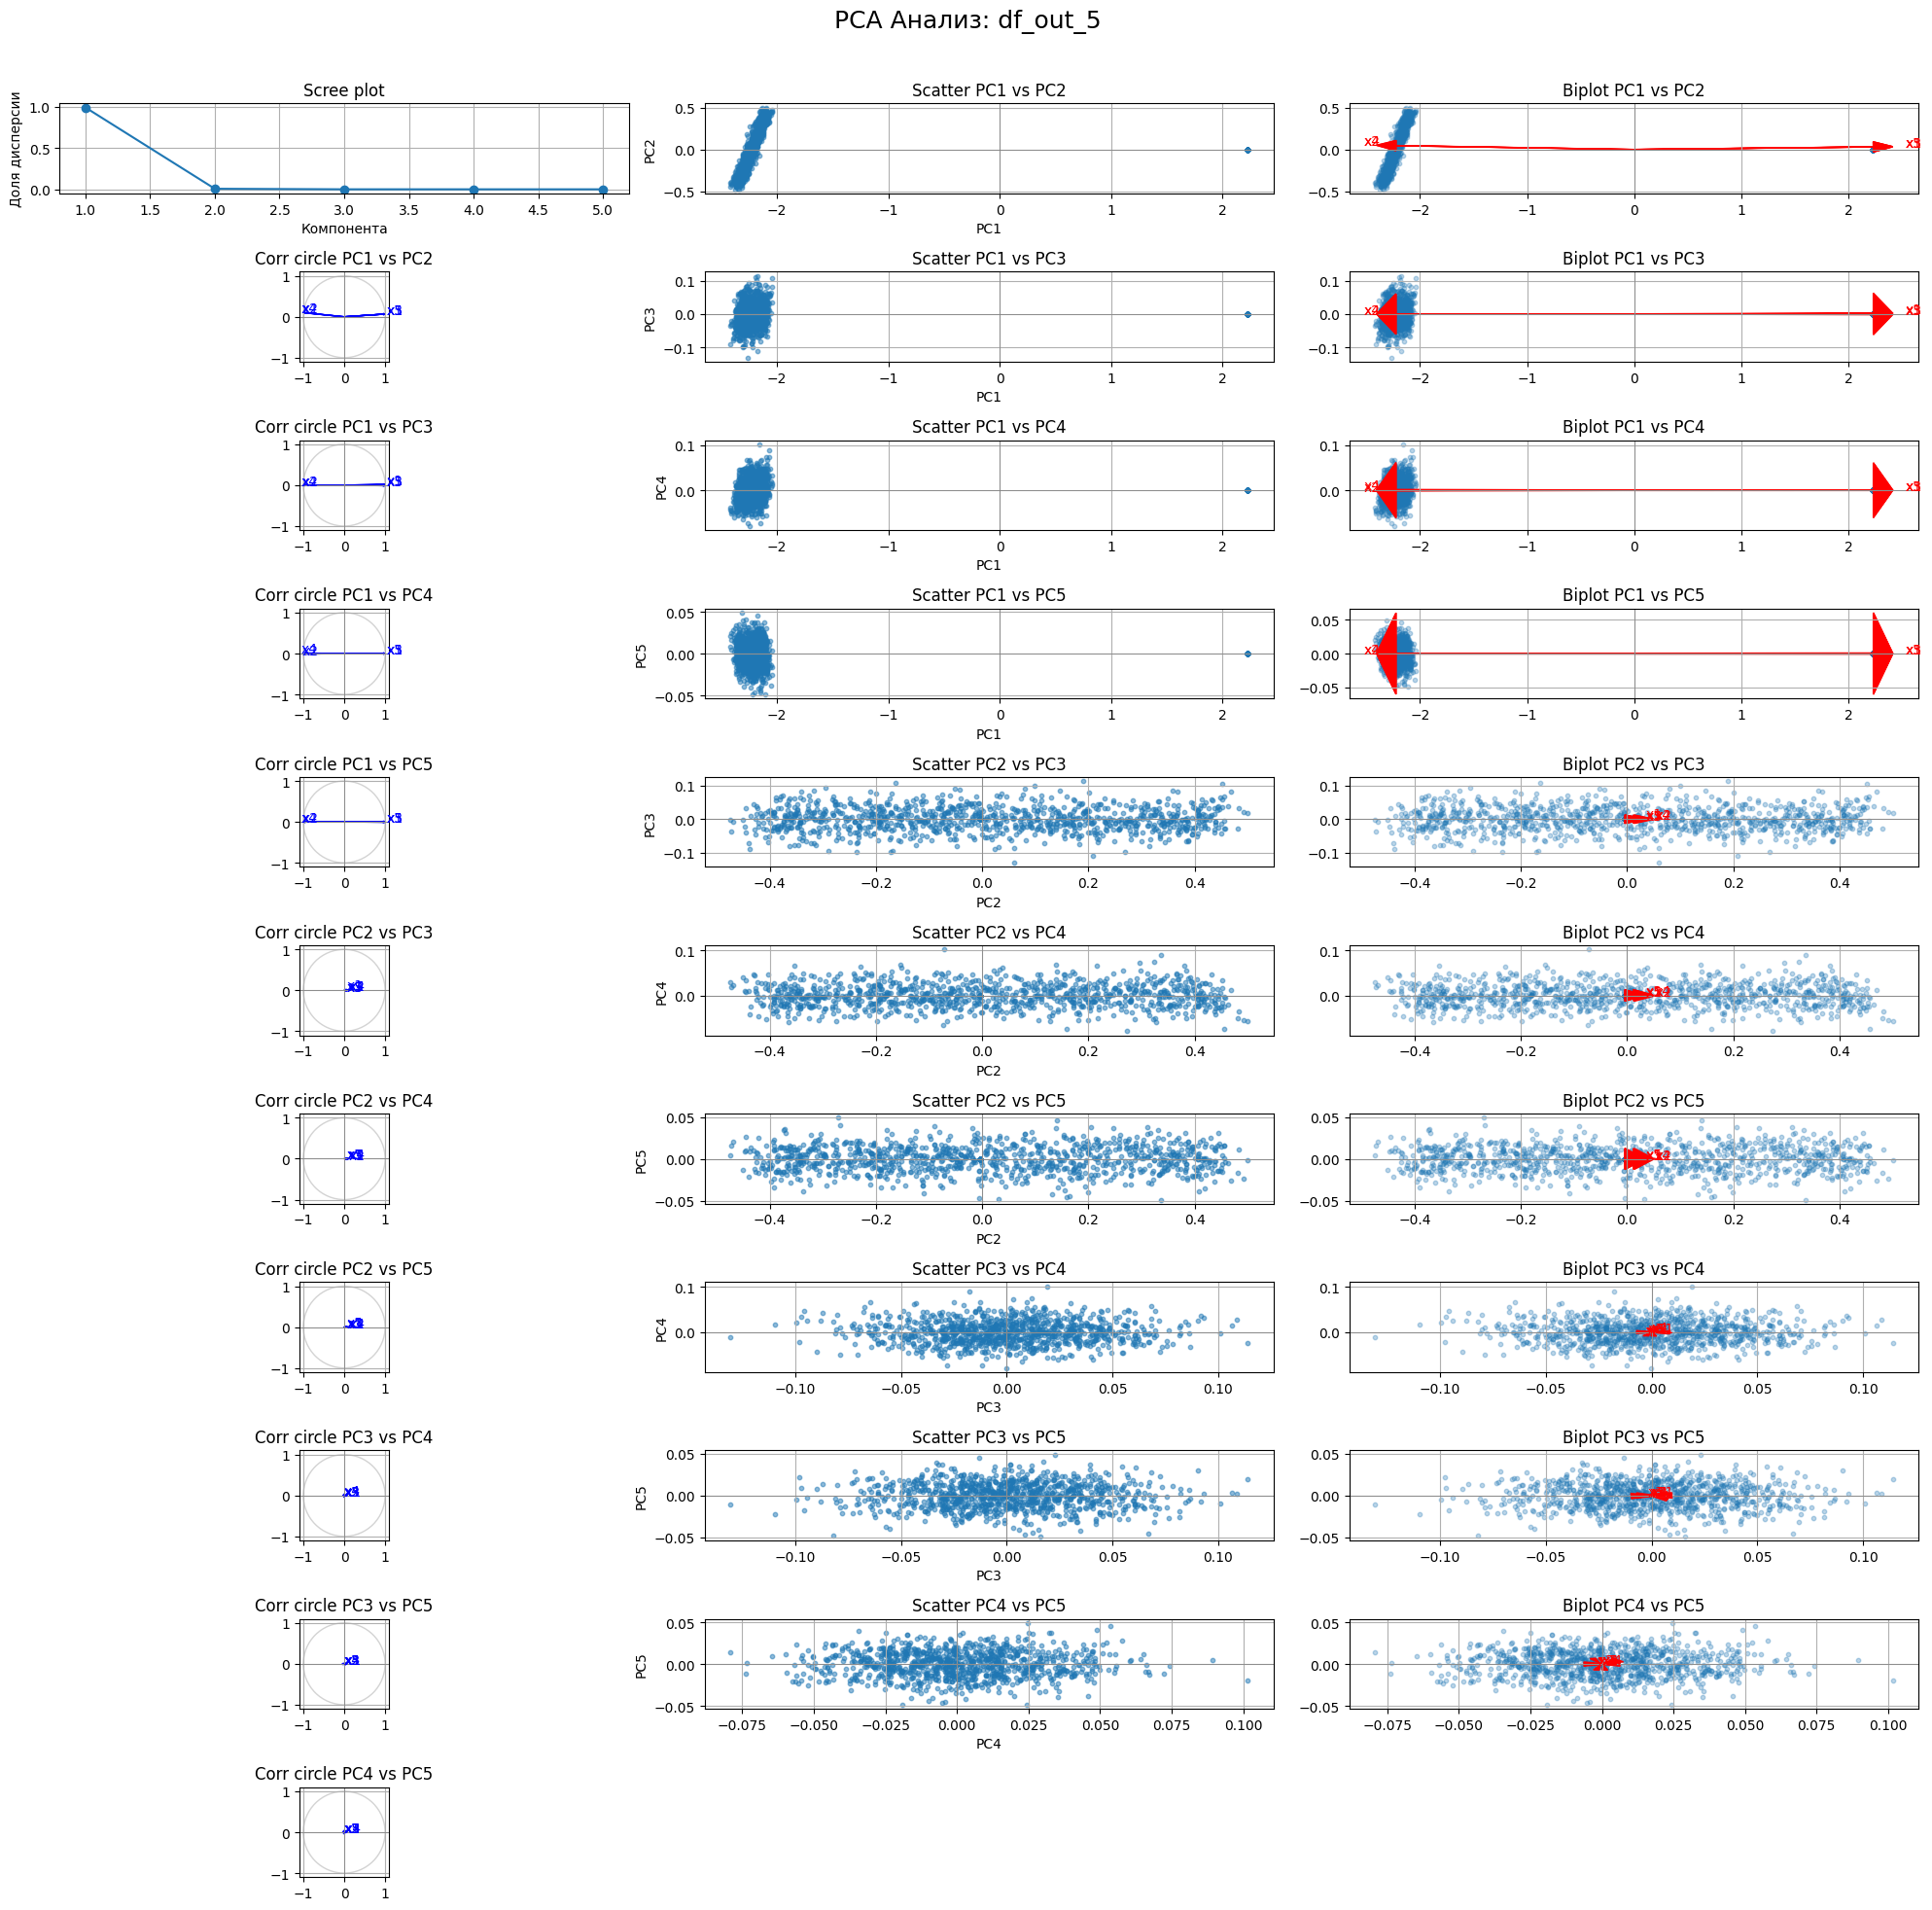

PCA для df_out_10


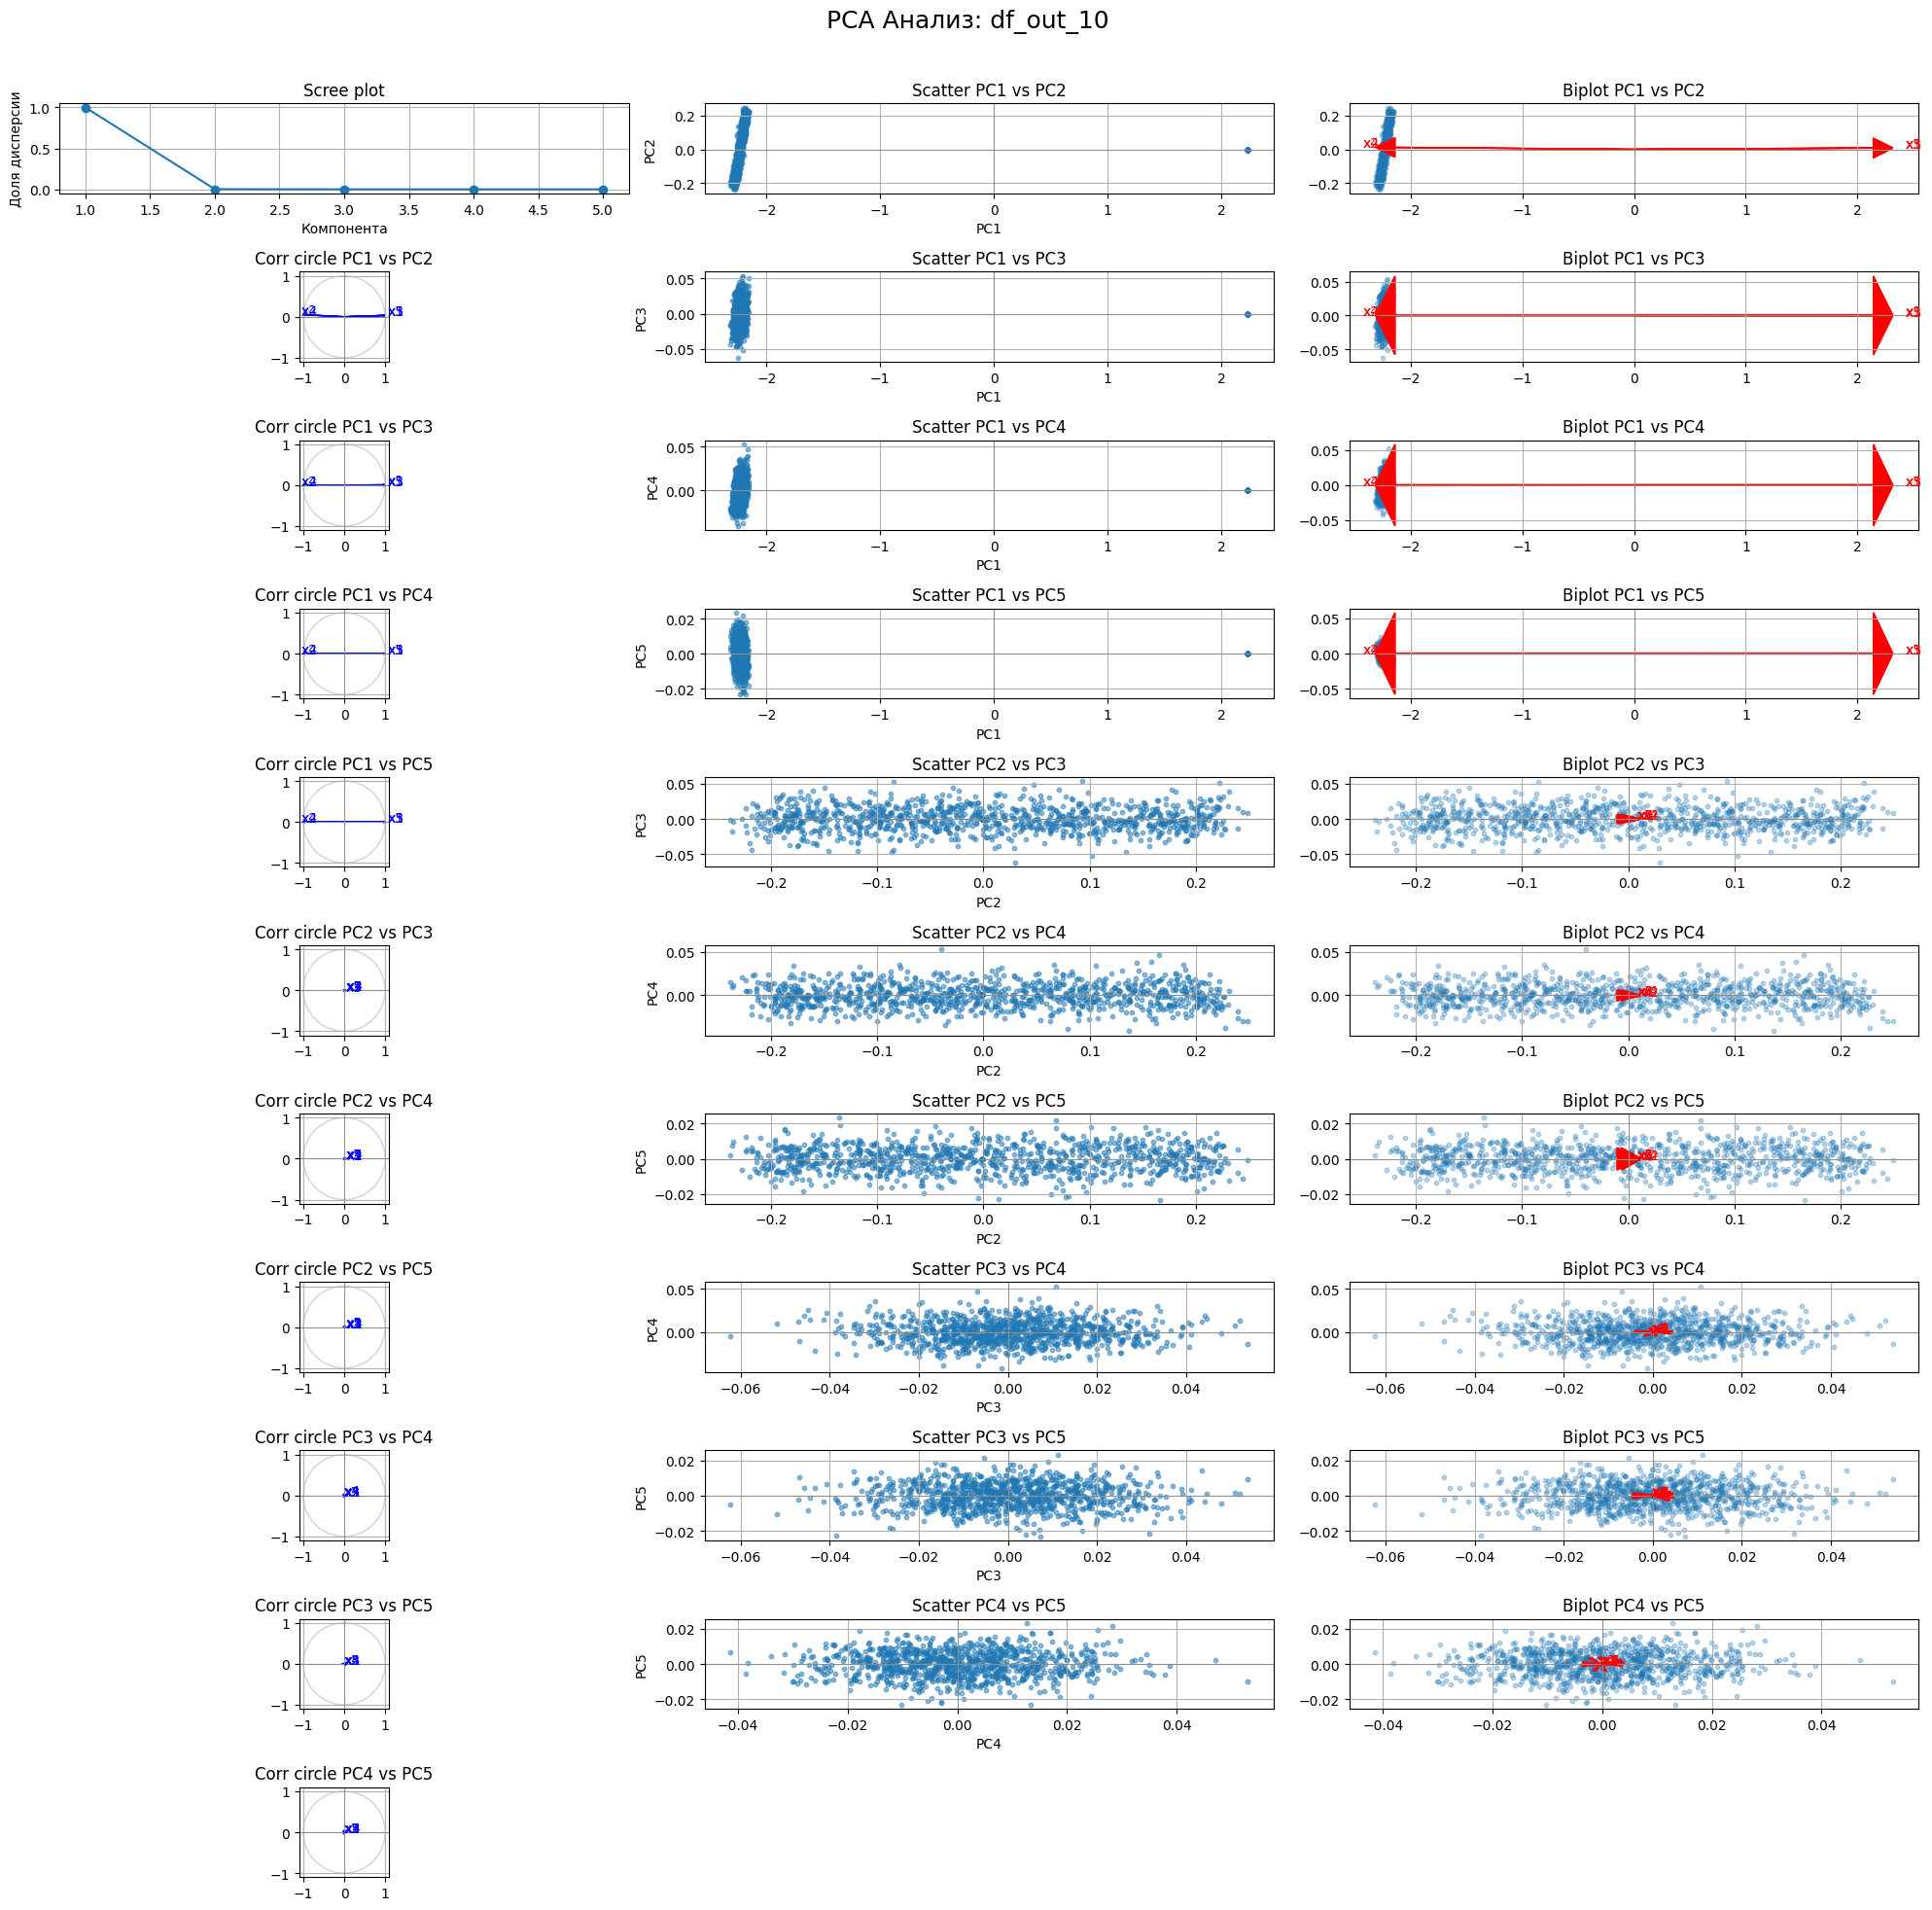

In [27]:
feature_cols_5d = list(df.columns)

print('PCA для df')
pca_df, Xs_df, Xpca_df, corr_df = pca_full_analysis(
    df,
    feature_cols_5d,
    dataset_name='df',
    standardize=True,
)

for i, df_out_i in dfs_out.items():
    print(f'PCA для df_out_{i}')
    pca_full_analysis(
        df_out_i,
        feature_cols_5d,
        dataset_name=f'df_out_{i}',
        standardize=True,
    )

Scree-plot отображает долю объясненной дисперсии каждой главной компонентой (PC1, PC2, PC3, ...)

Как интерпретировать
* PC1 объясняет больше всего дисперсии -> она соответствует направлению максимальной вариации данных
* PC2 объясняет вторую по величине дисперсию. она ортогональна PC1
* Чем более резкий спад дисперсий от компоненте к компоненте тем более выражена структура данных

Проекции объектов в пространстве пар главных компонент (scatter-plots PC1–PC2, PC1–PC3, …)
* Эти графики показывают как данные выглядят после вращения и сжатия PCA

Biplot объединяет:
* трансформированные точки данных в пространстве ПК
* стрелки старых признаков показывающие вклад каждого исходного признака в PC1 и PC2

[4] Используя методы UMAP, PacMAP и tSNE, для каждого датасета (df и df
out
_
_
i)
отдельно визуализировать проекции c нескольких (не менее 4) рендом-стартов, а также
после предвращения датасетов методом PCA.

In [ ]:
def run_manifold_methods_grid(
    X,
    y=None,
    dataset_name='dataset',
    n_neighbors=15,
    n_components=2,
    n_random_starts=4,
    use_pca_first=False,
    n_pca_components=None,
):
    """
    UMAP + tSNE + PaCMAP в одном большом subplot-grid.
    """
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # PCA
    if use_pca_first:
        if n_pca_components is None:
            n_pca_components = min(X_scaled.shape[1], 50)
        pca = PCA(n_components=n_pca_components)
        X_for_emb = pca.fit_transform(X_scaled)
        title_suffix = f" (PCA→{n_pca_components})"
    else:
        X_for_emb = X_scaled
        title_suffix = " (raw)"

    # Конфигурация сетки
    methods = ['UMAP', 'tSNE', 'PaCMAP']
    n_methods = len(methods)

    fig, axes = plt.subplots(
        n_methods,
        n_random_starts,
        figsize=(4 * n_random_starts, 4 * n_methods)
    )

    if n_methods == 1:
        axes = np.array([axes])

    if n_random_starts == 1:
        axes = axes.reshape(n_methods, 1)

    # Основной цикл
    for row, method in enumerate(methods):
        for col in range(n_random_starts):

            ax = axes[row, col]
            seed = col

            # UMAP 
            if method == 'UMAP' and umap is not None:
                reducer = umap.UMAP(
                    n_components=n_components,
                    n_neighbors=min(n_neighbors, X_for_emb.shape[0]-1),
                    init='random',
                    random_state=seed
                )
                Z = reducer.fit_transform(X_for_emb)

            # t-SNE
            elif method == 'tSNE':
                tsne = TSNE(
                    n_components=n_components,
                    random_state=seed,
                    init='random',
                    learning_rate='auto'
                )
                Z = tsne.fit_transform(X_for_emb)

            # PaCMAP
            elif method == 'PaCMAP' and pacmap is not None:
                try:
                    n_samples = X_for_emb.shape[0]
                    max_nn = max(1, n_samples - 51)
                    nn_pac = min(n_neighbors, max_nn)

                    embedding = pacmap.PaCMAP(
                        n_components=n_components,
                        n_neighbors=nn_pac,
                        random_state=seed
                    )
                    Z = embedding.fit_transform(
                        X_for_emb + np.random.normal(scale=1e-6, size=X_for_emb.shape),
                        init='random'
                    )
                except Exception:
                    ax.text(0.5, 0.5, "PaCMAP failed", ha='center', va='center')
                    ax.set_xticks([])
                    ax.set_yticks([])
                    continue

            else:
                ax.text(0.5, 0.5, method + " not available",
                        ha='center', va='center')
                ax.set_xticks([])
                ax.set_yticks([])
                continue

            # Отрисовка
            if y is None:
                ax.scatter(Z[:, 0], Z[:, 1], s=5, alpha=0.7)
            else:
                for cls in np.unique(y):
                    idx = (y == cls)
                    ax.scatter(Z[idx, 0], Z[idx, 1],
                               s=5, alpha=0.7, label=str(cls))
                if col == n_random_starts - 1:
                    ax.legend(fontsize=8)

            ax.set_title(f"{method}, seed={seed}")
            ax.set_xticks([])
            ax.set_yticks([])

    fig.suptitle(f"{dataset_name}{title_suffix}", fontsize=16)
    plt.tight_layout()
    plt.show()

нелинейные методы для df (4 random starts, без PCA и с PCA)

/Users/andrejtiskin/Develop/Study/StatisticalDecisionTheory/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/andrejtiskin/Develop/Study/StatisticalDecisionTheory/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/andrejtiskin/Develop/Study/StatisticalDecisionTheory/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/andrejtiskin/Develop/Study/StatisticalDecisionTheory/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


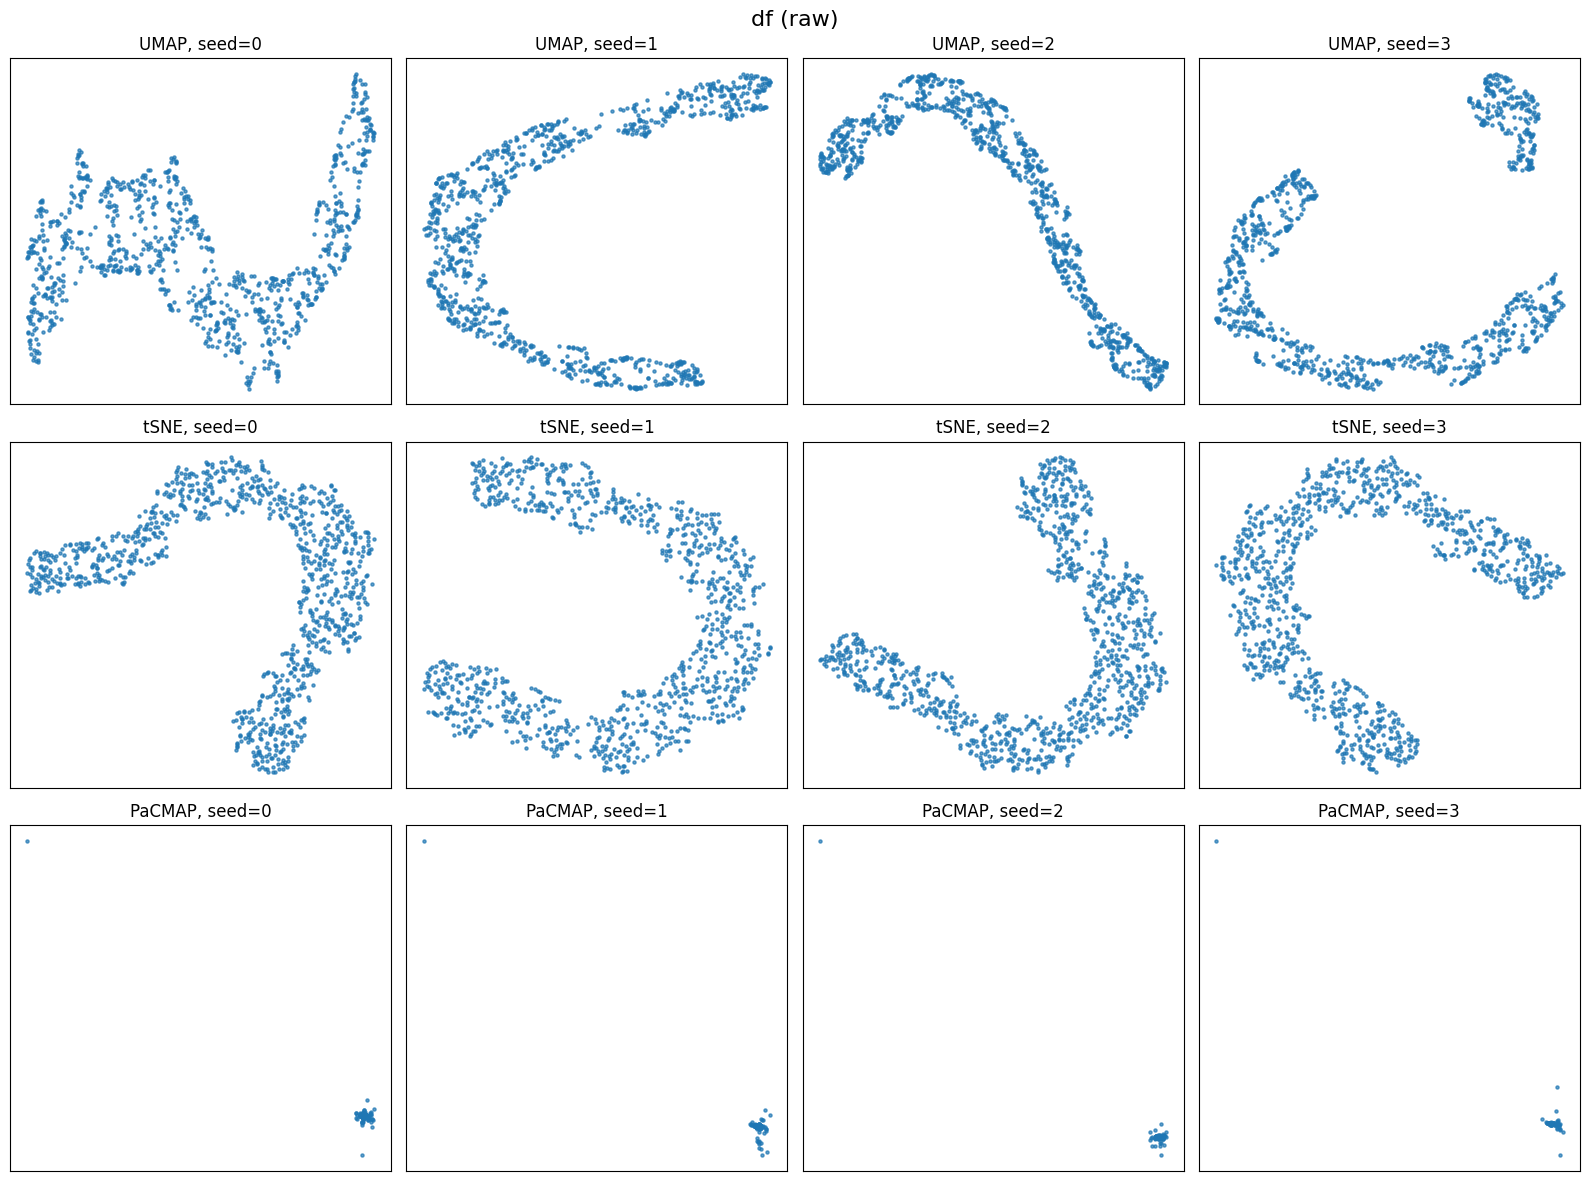

/Users/andrejtiskin/Develop/Study/StatisticalDecisionTheory/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/andrejtiskin/Develop/Study/StatisticalDecisionTheory/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/andrejtiskin/Develop/Study/StatisticalDecisionTheory/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/andrejtiskin/Develop/Study/StatisticalDecisionTheory/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


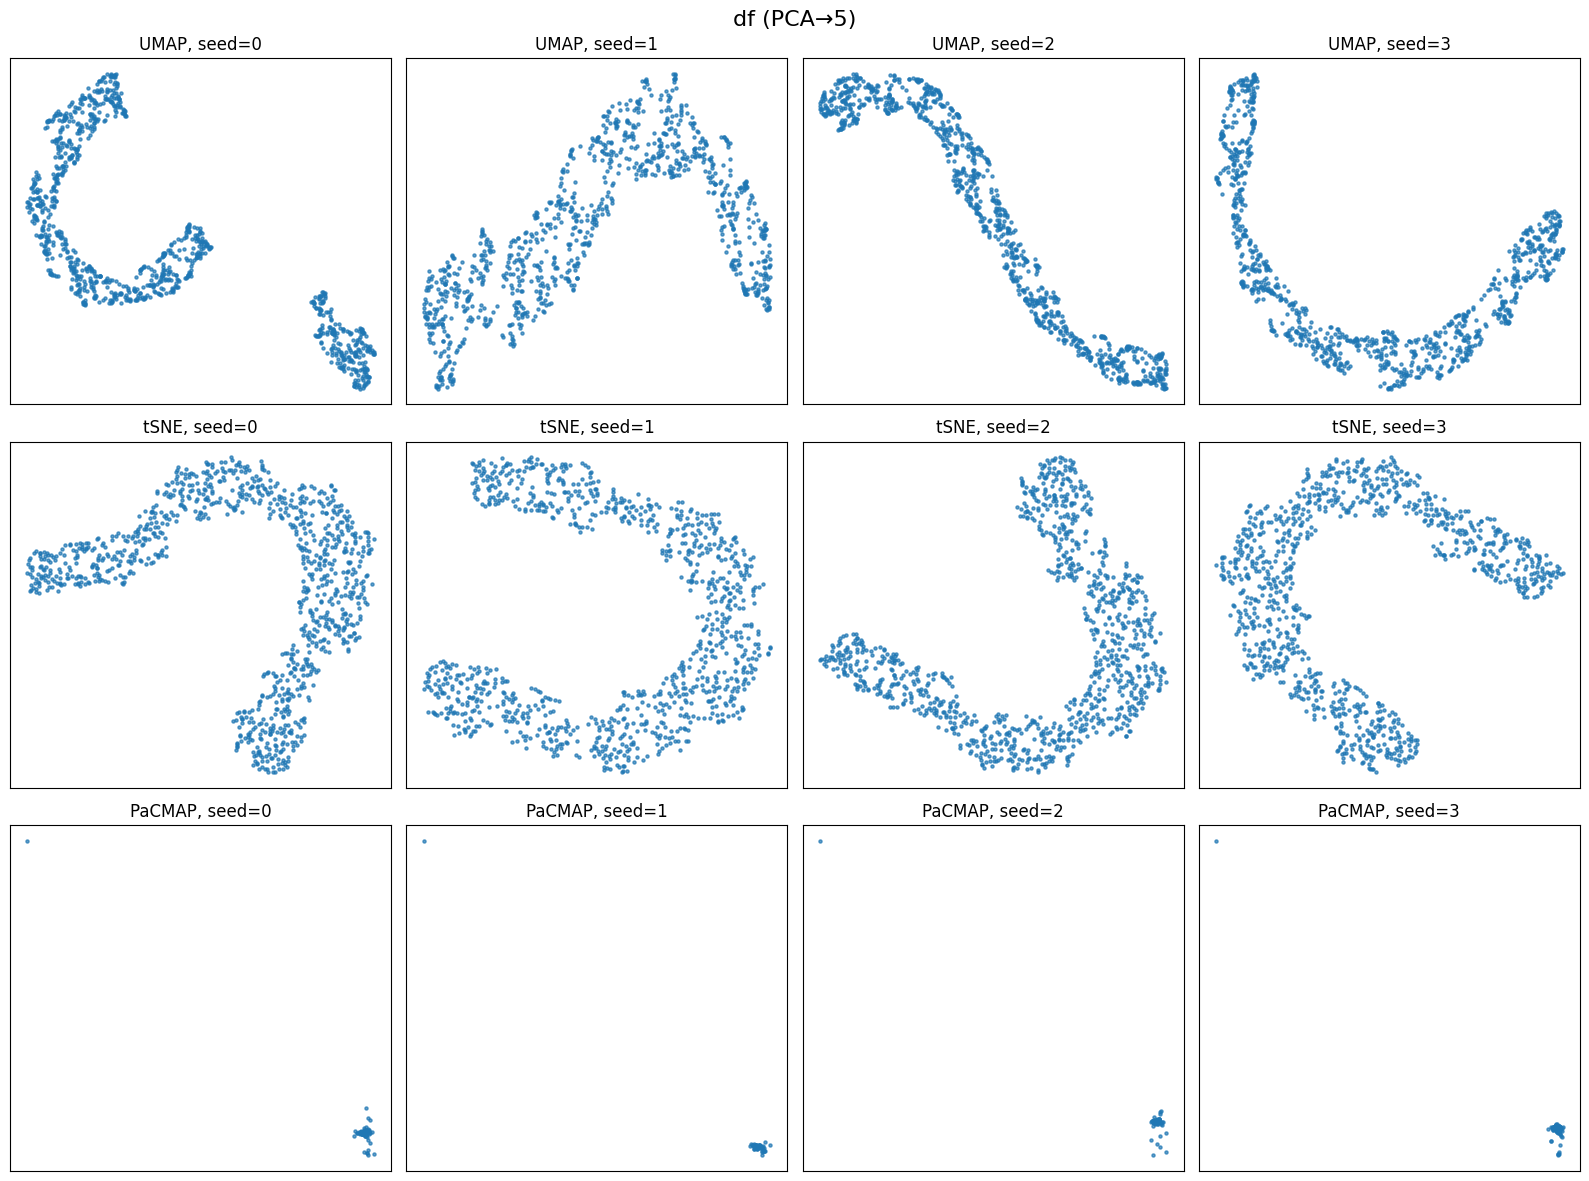


Нелинейные методы для df_out_1


/Users/andrejtiskin/Develop/Study/StatisticalDecisionTheory/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


KeyboardInterrupt: 

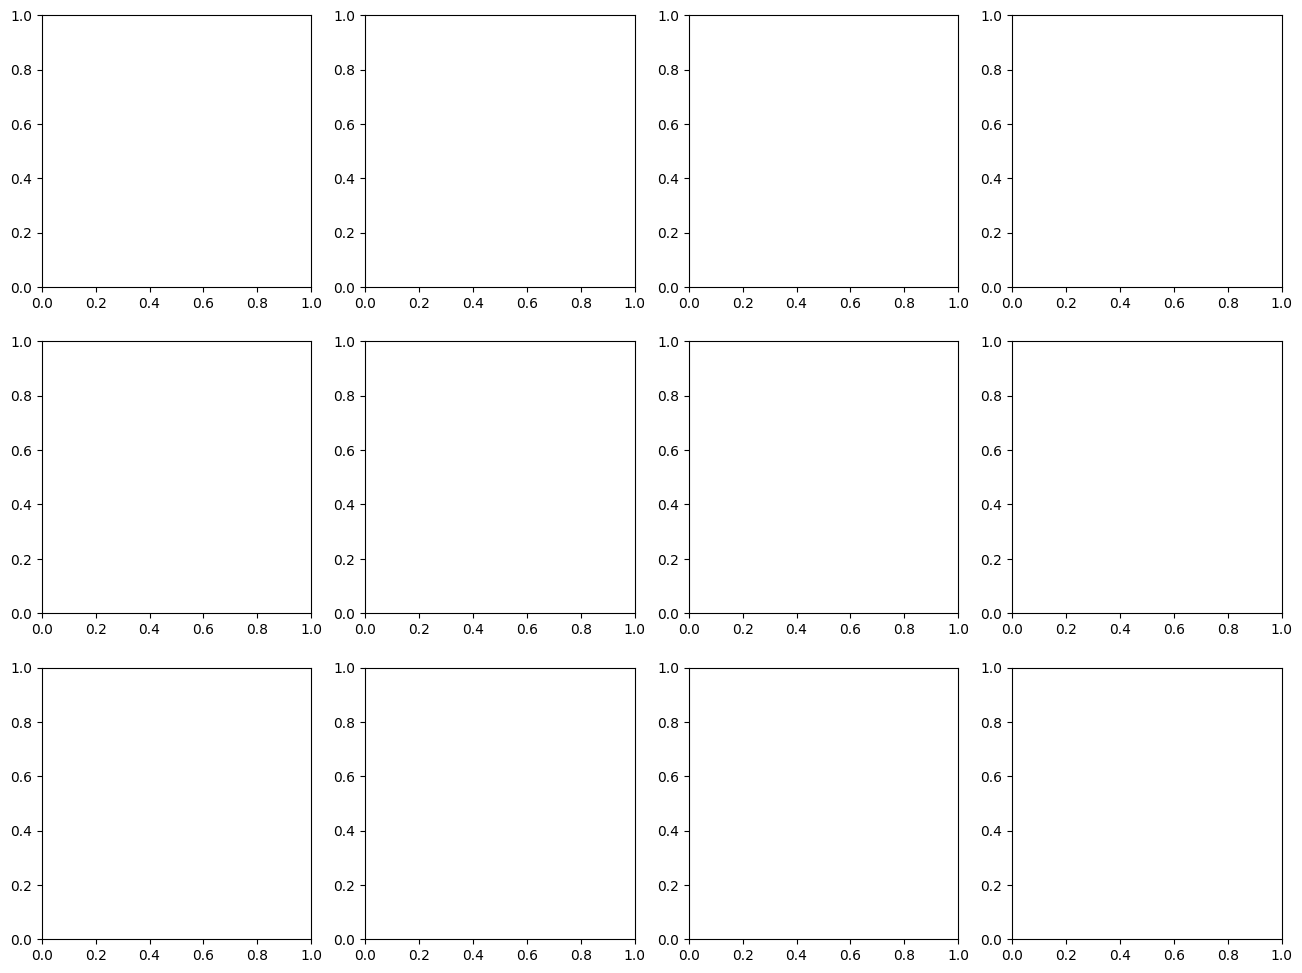

In [41]:
X_df = df[feature_cols_5d].values

# df без PCA
run_manifold_methods_grid(
    X_df,
    y=None,
    dataset_name='df',
    n_neighbors=15,
    n_components=2,
    n_random_starts=4,
    use_pca_first=False,
)

# df с предварительным PCA
run_manifold_methods_grid(
    X_df,
    y=None,
    dataset_name='df',
    n_neighbors=15,
    n_components=2,
    n_random_starts=4,
    use_pca_first=True,
    n_pca_components=5,
)

# df_out_i
for i, df_out_i in dfs_out.items():
    print(f'\nНелинейные методы для df_out_{i}')

    X_out = df_out_i[feature_cols_5d].values
    y_out = df_out_i['is_outlier'].values

    # без PCA
    run_manifold_methods_grid(
        X_out,
        y=y_out,
        dataset_name=f'df_out_{i}',
        n_neighbors=15,
        n_components=2,
        n_random_starts=4,
        use_pca_first=False,
    )

    # с PCA
    run_manifold_methods_grid(
        X_out,
        y=y_out,
        dataset_name=f'df_out_{i}',
        n_neighbors=15,
        n_components=2,
        n_random_starts=4,
        use_pca_first=True,
        n_pca_components=5,
    )

На датасетах df_out_i алгоритм PaCMAP не смог построить корректную
низкоразмерную проекцию для некоторых датасетов.

* Если df_out_i содержит 1000 абсолютно одинаковых точек выбросов
что приводит к вырождению пространства и нарушению
предположений алгоритма PaCMAP о существовании достаточного числа
различимых соседей

* Faiss/Annoy используемые внутри PaCMAP в таких ситуациях возвращают
пустые списки ближайших соседей что делает запуск алгоритма невозможным.

* визуализации PaCMAP для df_out_i не включены из за техническимих ограничений реализации PaCMAP

* Для df без выбросов PaCMAP работает корректно

[5] Сгенерировать и визуализировать на парах признаков 4-мерный датасет df
LDA из двух классов (каждый размером 1000 точек), в котором отдельные точки данных первого
класса расположены вдоль линии с началом (0,0,0,0) и завершением (+A,+A,+A,+A),
отдельные точки данных второго класса расположены вдоль линии с началом
(+A/100,0,0,0) и завершением (+A+A/100,+A,+A,+A), с дисперсиями для каждого класса
вдоль осей A/200000.

4D датасет df_LDA из [5]
- класс 1: линия (0,0,0,0) - (A,A,A,A)
- класс 2: линия (A/100,0,0,0) - (A+A/100,A,A,A)
- дисперсии вдоль осей A/200000 трактуем как variance

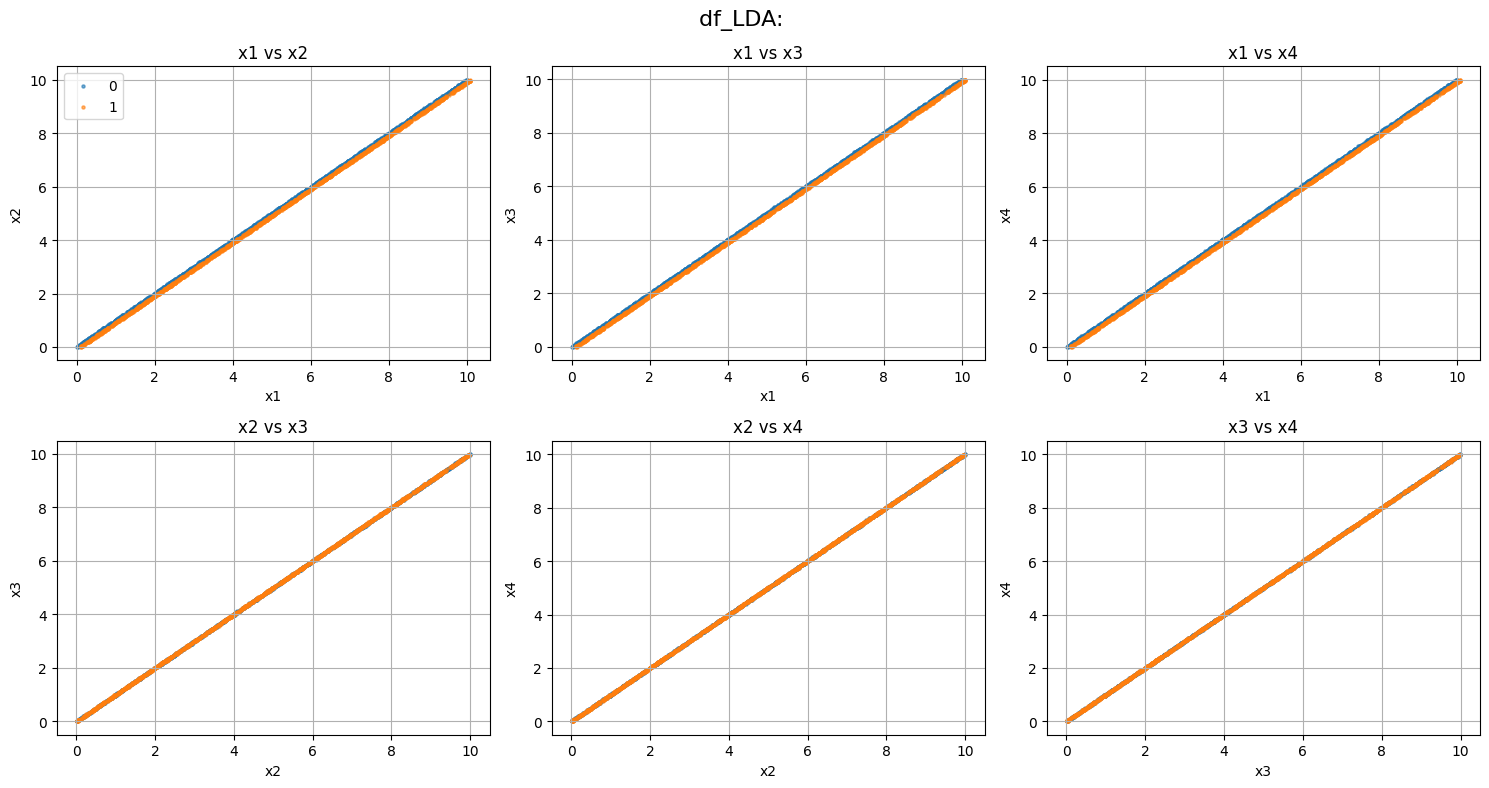

In [30]:
rng = np.random.RandomState(random_state)

var = A / 200000.0
sigma = np.sqrt(var)

# класс 0
t0 = rng.rand(1000, 1)
start0 = np.array([0.0, 0.0, 0.0, 0.0])
end0 = np.array([A, A, A, A])
base0 = start0 + t0 * (end0 - start0)
noise0 = rng.normal(scale=sigma, size=base0.shape)
X0 = base0 + noise0

# класс 1
t1 = rng.rand(1000, 1)
start1 = np.array([A / 100.0, 0.0, 0.0, 0.0])
end1 = np.array([A + A / 100.0, A, A, A])
base1 = start1 + t1 * (end1 - start1)
noise1 = rng.normal(scale=sigma, size=base1.shape)
X1 = base1 + noise1

X = np.vstack([X0, X1])
y = np.array([0] * 1000 + [1] * 1000)

cols = [f'x{i}' for i in range(1, 5)]
df_lda = pd.DataFrame(X, columns=cols)
df_lda['class'] = y


feature_cols_lda = [f'x{i}' for i in range(1, 5)]

plot_feature_pairs_single_figure(df_lda, feature_cols_lda,
hue='class', title='df_LDA: ')

df_LDA датасет из двух классов

* первый лежит вдоль линии (0,0,0,0) , (A, A, A, A) с очень маленькой дисперсией A/200000
* второй лежит вдоль линии (A/100, 0, 0, 0) , (A + A/100, A, A, A) т.е. это та же самая линия но сдвинутая по первой координате на A/100.
<br>
шум очень маленький поэтому точки каждого класса — почти идеальные линии.

* Графики с осью x1 показывают чёткое разделение классов
-> x1 - главный дискриминант
* Графики без x1 показывают полное наложение классов
-> x2 x3 x4 не помогают в классификации.
* Каждый класс образует почти идеальную прямую линию
-> структура данных линейная и шум минимальный
* Сдвиг между классами мал и проявляется только в x1

[6] Используя метод главных компонент (основанный на корреляциях), для датасета
df
_
LDA из пункта [5] выполнить визуализации аналогично подпунктам пункта [3].

Полный PCA-анализ для 3, 6, 10
* scree plot
* проекции объектов на пары ГК
* biplot объекты + старые переменные
* корреляционный круг corr(vars, PCs)
<br>
PCA основан на корреляциях. предварительно стандартизируем признаки

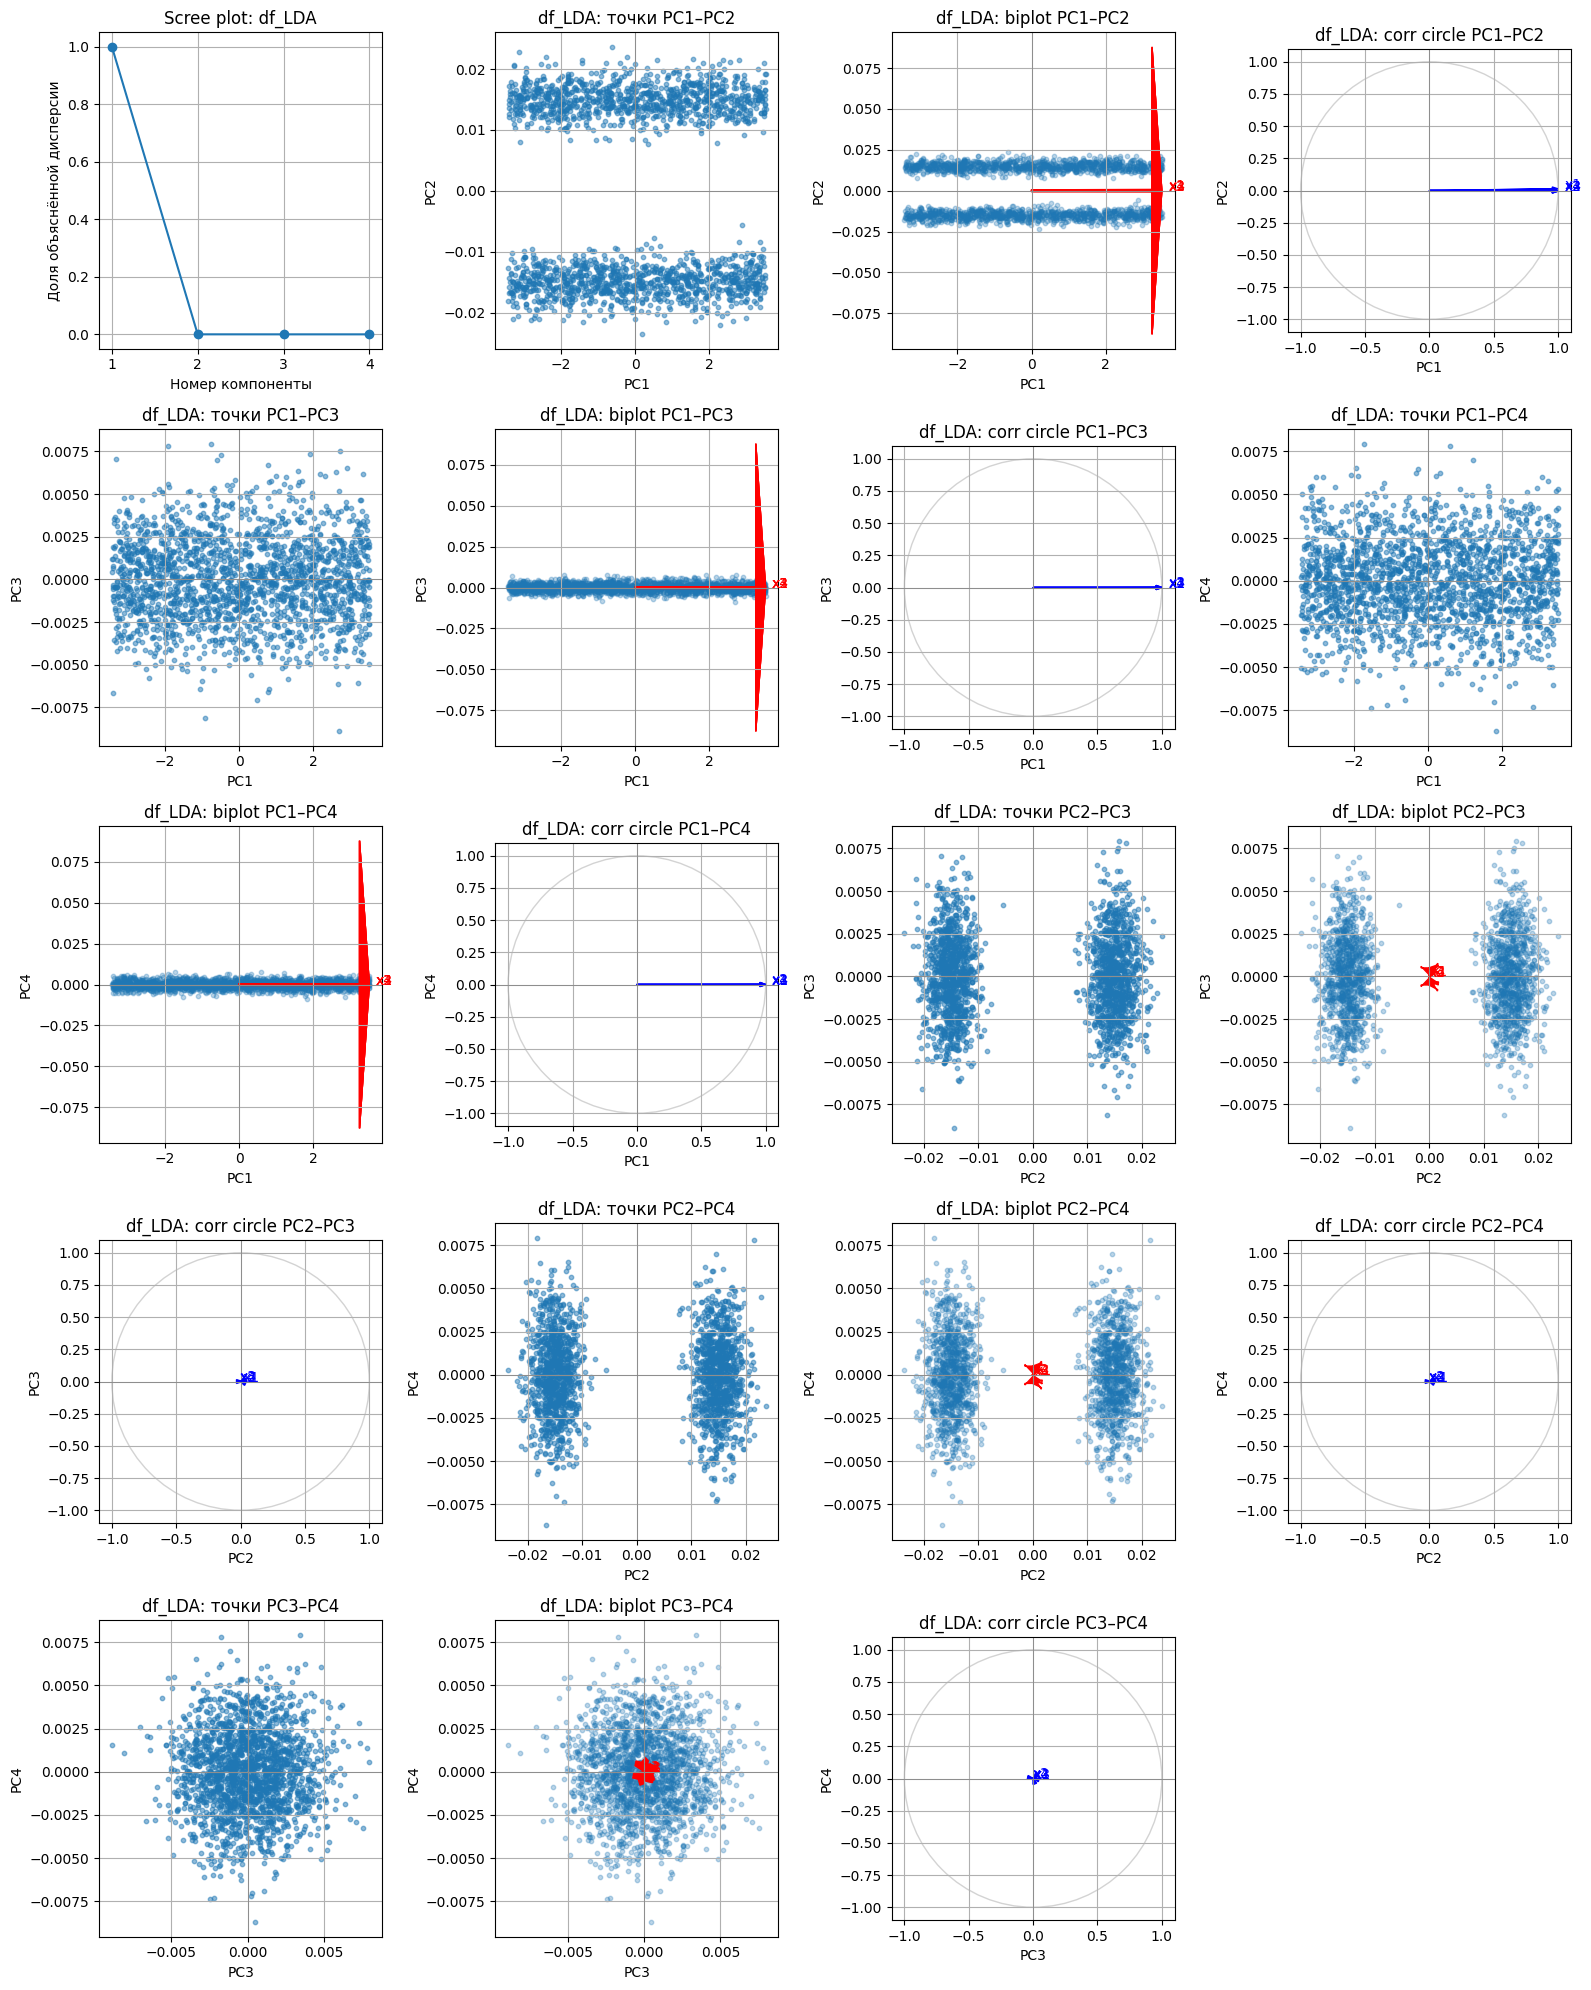

In [31]:
dataset_name = 'df_LDA'
standardize = True
max_components_to_plot = None

X = df_lda[feature_cols_lda].values
if standardize:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
else:
    X_scaled = X

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

n_comp = X_pca.shape[1]
if max_components_to_plot is None:
    comp_indices = list(range(n_comp))
else:
    comp_indices = list(range(min(max_components_to_plot, n_comp)))

# корреляции переменных с ГК
corr = np.corrcoef(X_scaled.T, X_pca.T)[: len(feature_cols_lda),
                                        len(feature_cols_lda):]

# пары главных компонент все
pairs = list(combinations(comp_indices, 2))

# создаем большую сетку для отрисовки 
n_pairs = len(pairs)
plots_per_pair = 3   # objects, biplot, circle
total_plots = 1 + n_pairs * plots_per_pair  # +1 scree

cols = 4
rows = int(np.ceil(total_plots / cols))

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
axes = axes.flatten()

plot_idx = 0

# Scree plot
ax = axes[plot_idx]
plot_idx += 1

ax.plot(range(1, n_comp + 1),
        pca.explained_variance_ratio_, 'o-')
ax.set_xticks(range(1, n_comp + 1))
ax.set_xlabel('Номер компоненты')
ax.set_ylabel('Доля объяснённой дисперсии')
ax.set_title(f'Scree plot: {dataset_name}')
ax.grid(True)

# Все пары: объекты biplot circle
for a, b in pairs:

    # Объекты в PCa - PCb
    ax = axes[plot_idx]
    plot_idx += 1
    ax.scatter(X_pca[:, a], X_pca[:, b], s=10, alpha=0.5)
    ax.axhline(0, color='grey', linewidth=0.5)
    ax.axvline(0, color='grey', linewidth=0.5)
    ax.set_xlabel(f'PC{a+1}')
    ax.set_ylabel(f'PC{b+1}')
    ax.set_title(f'{dataset_name}: точки PC{a+1}–PC{b+1}')
    ax.grid(True)

    # Biplot
    ax = axes[plot_idx]
    plot_idx += 1
    ax.scatter(X_pca[:, a], X_pca[:, b], s=10, alpha=0.3)

    max_x = np.max(np.abs(X_pca[:, a]))
    max_y = np.max(np.abs(X_pca[:, b]))

    for i, feat in enumerate(feature_cols_lda):
        vx = corr[i, a] * max_x
        vy = corr[i, b] * max_y
        ax.arrow(0, 0, vx, vy,
                 head_width=0.05 * max_x,
                 length_includes_head=True,
                 color='red')
        ax.text(vx * 1.05, vy * 1.05, feat, color='red')

    ax.axhline(0, color='grey', linewidth=0.5)
    ax.axvline(0, color='grey', linewidth=0.5)
    ax.set_xlabel(f'PC{a+1}')
    ax.set_ylabel(f'PC{b+1}')
    ax.set_title(f'{dataset_name}: biplot PC{a+1}–PC{b+1}')
    ax.grid(True)

    # Корреляционный круг
    ax = axes[plot_idx]
    plot_idx += 1

    circle = plt.Circle((0, 0), 1, color='lightgray', fill=False)
    ax.add_artist(circle)

    for i, feat in enumerate(feature_cols_lda):
        x = corr[i, a]
        y = corr[i, b]
        ax.arrow(0, 0, x, y,
                 head_width=0.03,
                 length_includes_head=True,
                 color='blue')
        ax.text(x * 1.05, y * 1.05, feat, color='blue')

    ax.axhline(0, color='grey', linewidth=0.5)
    ax.axvline(0, color='grey', linewidth=0.5)
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.set_aspect('equal', 'box')
    ax.set_xlabel(f'PC{a+1}')
    ax.set_ylabel(f'PC{b+1}')
    ax.set_title(f'{dataset_name}: corr circle PC{a+1}–PC{b+1}')
    ax.grid(True)

# удаляем пустые оси
for j in range(plot_idx, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

[7] Используя метод LDA, для датасета df
_
LDA из пункта [5] выполнить визуализации
решения LDA на всех парах переменных.

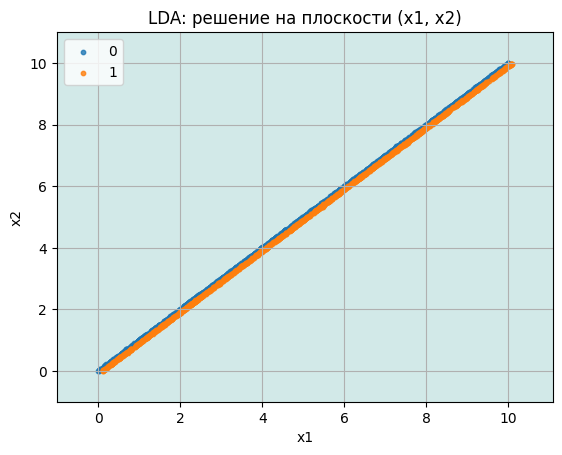

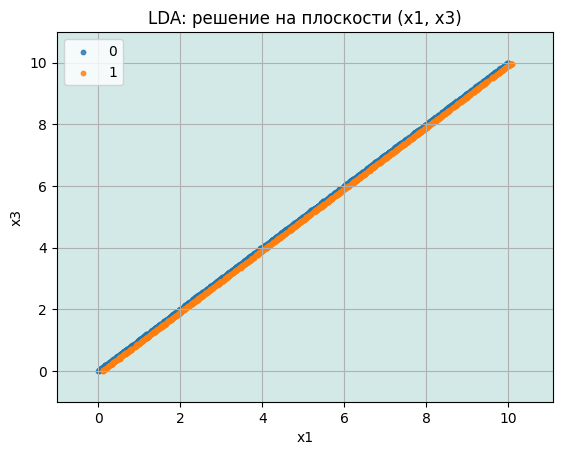

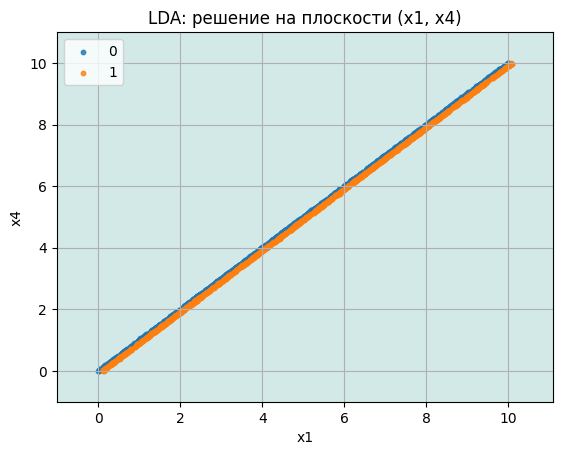

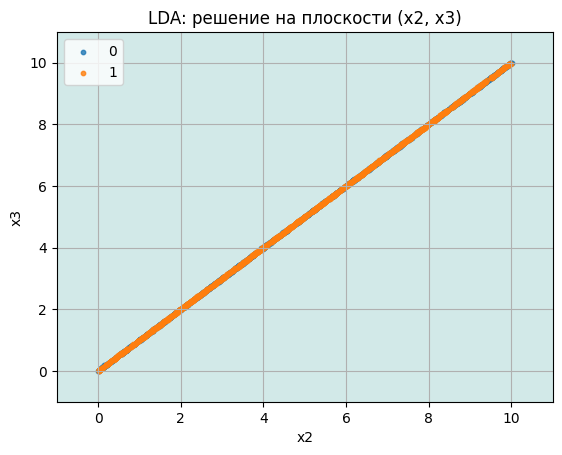

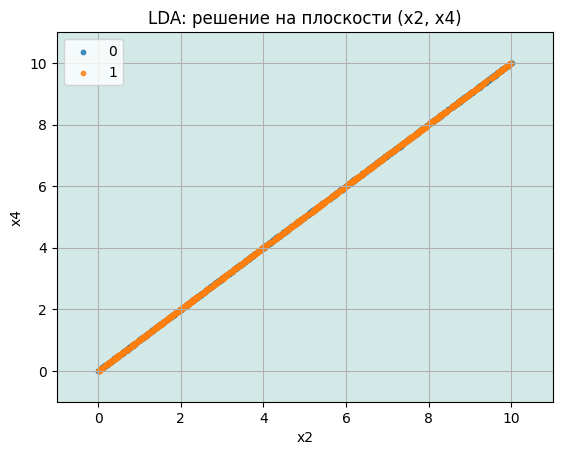

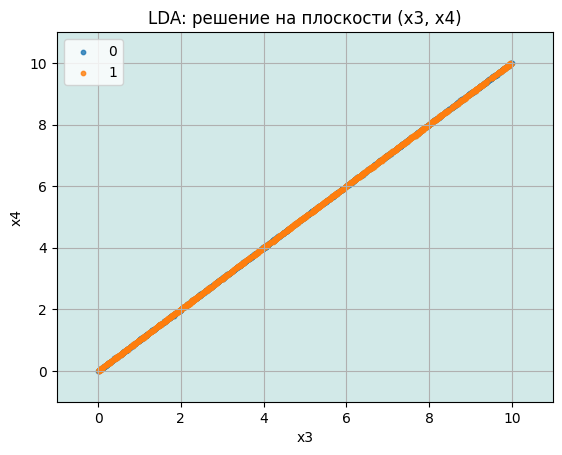

In [32]:
y = df_lda["class"].values

for f1, f2 in combinations(feature_cols_lda, 2):
    X_pair = df_lda[[f1, f2]].values
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_pair, y)

    x_min, x_max = X_pair[:, 0].min() - 1, X_pair[:, 0].max() + 1
    y_min, y_max = X_pair[:, 1].min() - 1, X_pair[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200),
    )
    Z = lda.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.2, levels=np.unique(y))
    for cls in np.unique(y):
        idx = (y == cls)
        plt.scatter(
            X_pair[idx, 0],
            X_pair[idx, 1],
            s=10,
            alpha=0.8,
            label=str(cls),
        )
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.title(f'LDA: решение на плоскости ({f1}, {f2})')
    plt.legend()
    plt.grid(True)
    plt.show()


* Чем меньше дисперсия по координате тем уже вытягивается облако. Картинка подтверждает что данные действительно одномерны т.е лежат близко к линии

* LDA дает мне одну и ту же границу т.к LDA ищет единственную линейную комбинацию признаков которая лучше всего разделяет классы. различаться есть только по x1 поэтому LDA находит одно и тоже каждый раз

[8] Взять с Kaggle датасет, в котором есть >=10 переменных, >=10000 объектов и
несколько классов.

In [33]:
import kagglehub
import pandas as pd

path = kagglehub.dataset_download("muratkokludataset/dry-bean-dataset")
print("Path to dataset files:", path)

df_k = pd.read_excel(path + "/Dry_Bean_Dataset/Dry_Bean_Dataset.xlsx")

print("Shape:", df_k.shape)
print(df_k.columns.tolist())
print("Классы:", df_k['Class'].unique(), "\nCounts:\n", df_k['Class'].value_counts())

target_col = df_k['Class']

# признаки / целевая
feature_cols = [c for c in df_k.columns if c != 'Class']
target = 'Class'
# X и y
X_k = df_k[feature_cols].values
y_k = df_k[target].values


df_k.head()

Path to dataset files: /Users/andrejtiskin/.cache/kagglehub/datasets/muratkokludataset/dry-bean-dataset/versions/1
Shape: (13611, 17)
['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4', 'Class']
Классы: ['SEKER' 'BARBUNYA' 'BOMBAY' 'CALI' 'HOROZ' 'SIRA' 'DERMASON'] 
Counts:
 Class
DERMASON    3546
SIRA        2636
SEKER       2027
HOROZ       1928
CALI        1630
BARBUNYA    1322
BOMBAY       522
Name: count, dtype: int64


Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRation  \
0  28395    610.291       208.178117       173.888747      1.197191   
1  28734    638.018       200.524796       182.734419      1.097356   
2  29380    624.110       212.826130       175.931143      1.209713   
3  30008    645.884       210.557999       182.516516      1.153638   
4  30140    620.134       201.847882       190.279279      1.060798   

   Eccentricity  ConvexArea  EquivDiameter    Extent  Solidity  roundness  \
0      0.549812       28715     190.141097  0.763923  0.988856   0.958027   
1      0.411785       29172     191.272750  0.783968  0.984986   0.887034   
2      0.562727       29690     193.410904  0.778113  0.989559   0.947849   
3      0.498616       30724     195.467062  0.782681  0.976696   0.903936   
4      0.333680       30417     195.896503  0.773098  0.990893   0.984877   

   Compactness  ShapeFactor1  ShapeFactor2  ShapeFactor3  ShapeFactor4  Class  
0     0.913358      0.007332      0.003147      0.834222      0.998724  SEKER  
1     0.953861      0.006979      0.003564      0.909851      0.998430  SEKER  
2     0.908774      0.007244      0.003048      0.825871      0.999066  SEKER  
3     0.928329      0.007017      0.003215      0.861794      0.994199  SEKER  
4     0.970516      0.006697      0.003665      0.941900      0.999166  SEKER

[9] Используя метод главных компонент (основанный на корреляциях), для датасета из
пункта [8] определить различными способами (метод Кайзера, метод ломанной трости),
сколько компонент необходимо оставлять для регрессионной модели.

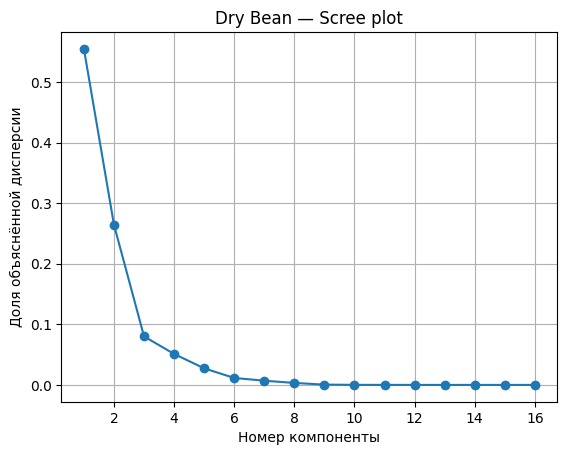

Метод Кайзера: оставить 3 компонент(ы)
Метод ломанной трости: оставить 2 компонент(ы)


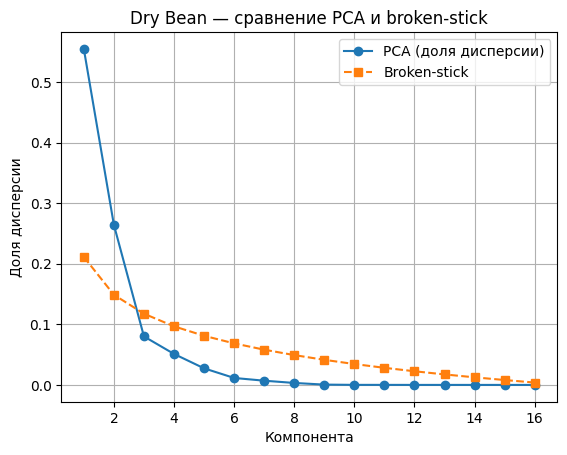

Для последующих пунктов будем использовать 3 компонент(ы)


In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# стандартизация
scaler_k = StandardScaler()
X_k_scaled = scaler_k.fit_transform(X_k)

# PCA без ограничения числа компонент
pca_k = PCA()
X_k_pca = pca_k.fit_transform(X_k_scaled)

# Scree plot
plt.figure()
plt.plot(
    range(1, len(pca_k.explained_variance_ratio_) + 1),
    pca_k.explained_variance_ratio_,
    'o-'
)
plt.xlabel("Номер компоненты")
plt.ylabel("Доля объяснённой дисперсии")
plt.title("Dry Bean — Scree plot")
plt.grid(True)
plt.show()

# метод Кайзера и ломанной трости

def broken_stick_values(p: int) -> np.ndarray:
    return np.array([np.sum(1.0 / np.arange(i, p + 1)) / p for i in range(1, p + 1)])

eigvals = pca_k.explained_variance_
ratios = pca_k.explained_variance_ratio_
p = len(eigvals)

bs_vals = broken_stick_values(p)

# метод Кайзера
n_kaiser = np.sum(eigvals > 1.0)

# метод ломанной трости
n_bs = np.sum(ratios > bs_vals)

print(f"Метод Кайзера: оставить {n_kaiser} компонент(ы)")
print(f"Метод ломанной трости: оставить {n_bs} компонент(ы)")

# визуализация broken-stick vs доли дисперсии
plt.figure()
plt.plot(range(1, p + 1), ratios, 'o-', label='PCA (доля дисперсии)')
plt.plot(range(1, p + 1), bs_vals, 's--', label='Broken-stick')
plt.xlabel("Компонента")
plt.ylabel("Доля дисперсии")
plt.title("Dry Bean — сравнение PCA и broken-stick")
plt.legend()
plt.grid(True)
plt.show()

# общее число компонент, которое будем использовать в следующих пунктах
n_keep = max(n_kaiser, n_bs)
print(f"Для последующих пунктов будем использовать {n_keep} компонент(ы)")

[10] Используя метод главных компонент (основанный на корреляциях), для датасета из
пункта [8] выполнить визуализации аналогично подпунктам пункта [3], с учетом числа
отобранных компонент.

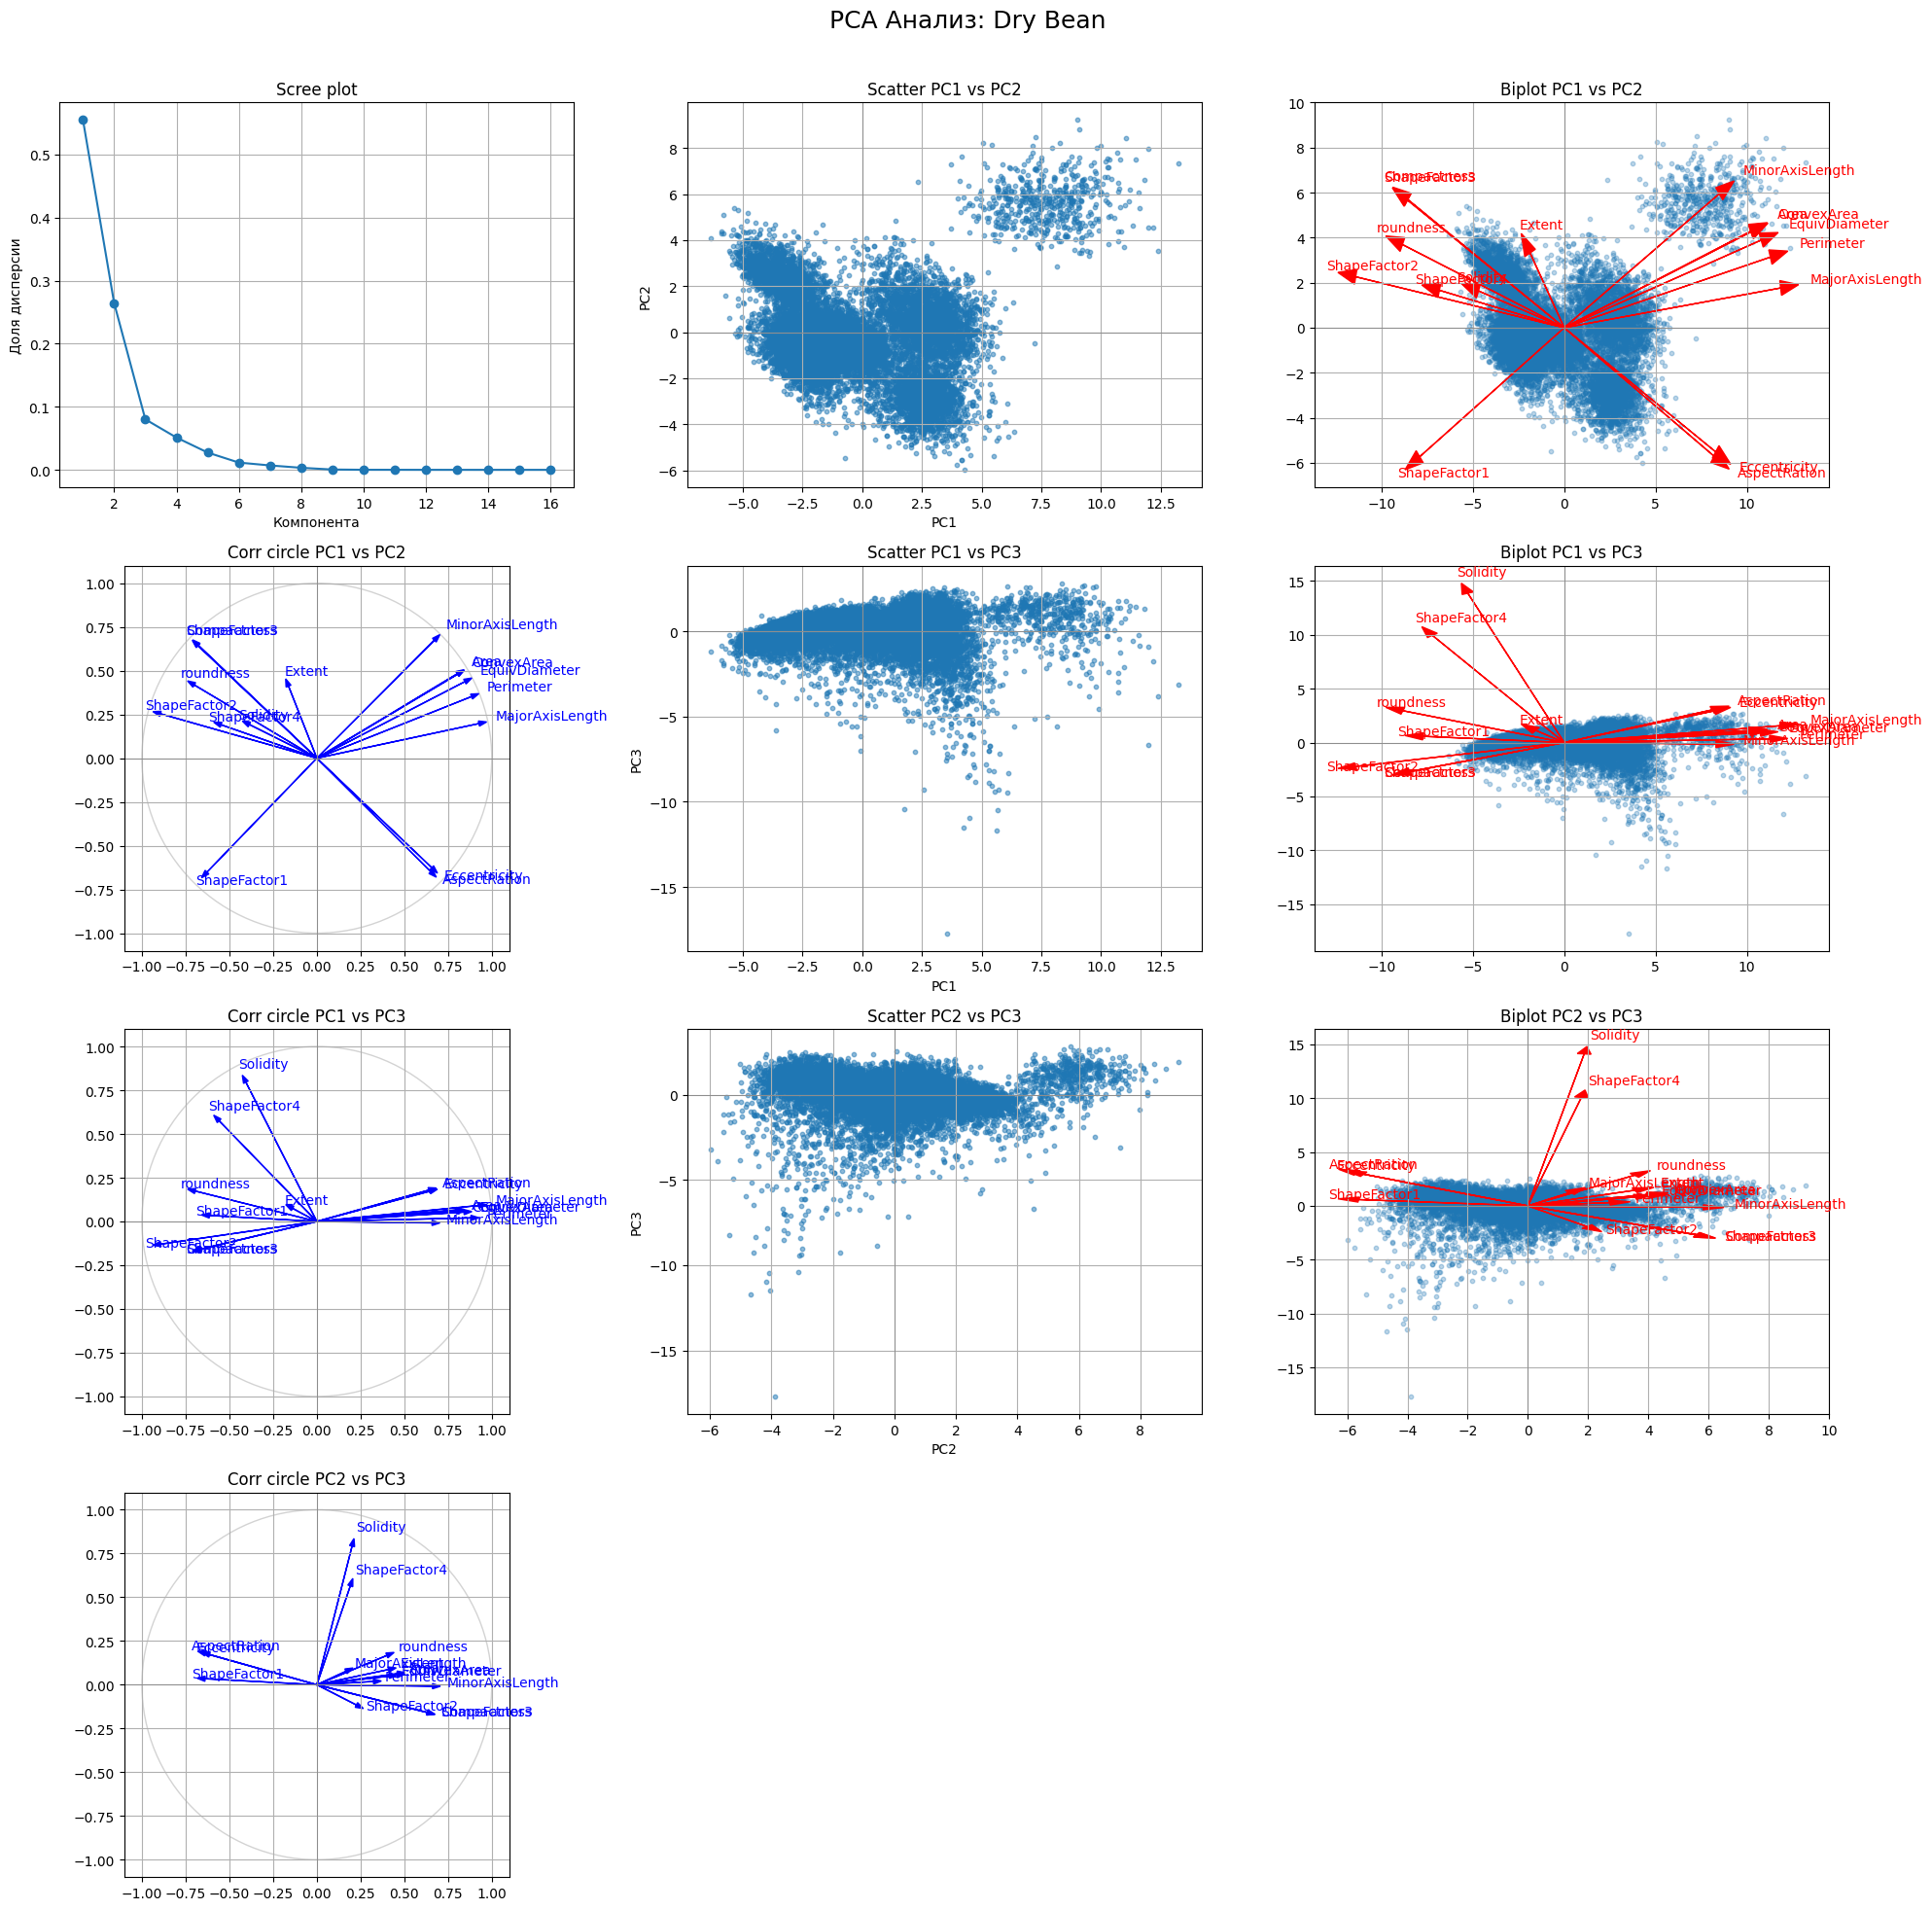

In [35]:
# предполагаем, что функция pca_full_analysis уже определена
pca_k2, X_k_scaled2, X_k_pca2, corr_k = pca_full_analysis(
    df_k,
    feature_cols=feature_cols,
    dataset_name='Dry Bean',
    standardize=True,
    max_components_to_plot=n_keep  # учитываем число отобранных компонент
)

[11] Используя методы UMAP, PacMAP и tSNE, для датасета из пункта [8] отдельно
визуализировать проекции c нескольких (не менее 2) рендом-стартов, а также после
предвращения датасетов методом PCA.

=== ПУНКТ 11: Нелинейные методы ===

Форма данных для PaCMAP (PCA10): (13611, 10)

=== (1) Нелинейные методы БЕЗ PCA ===



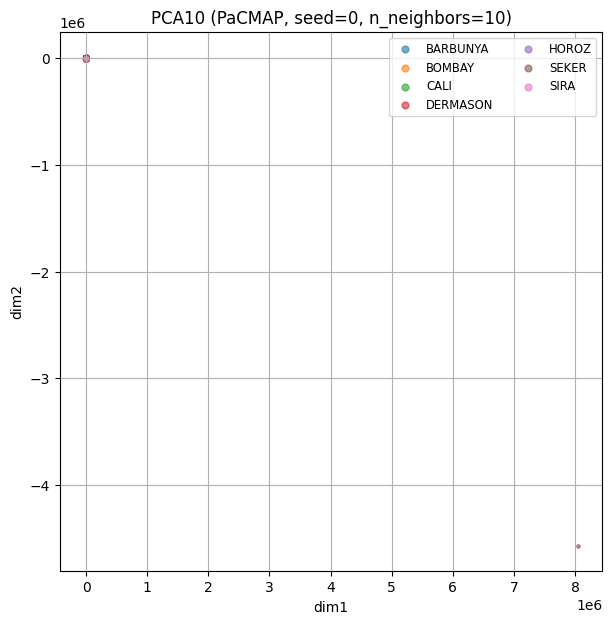

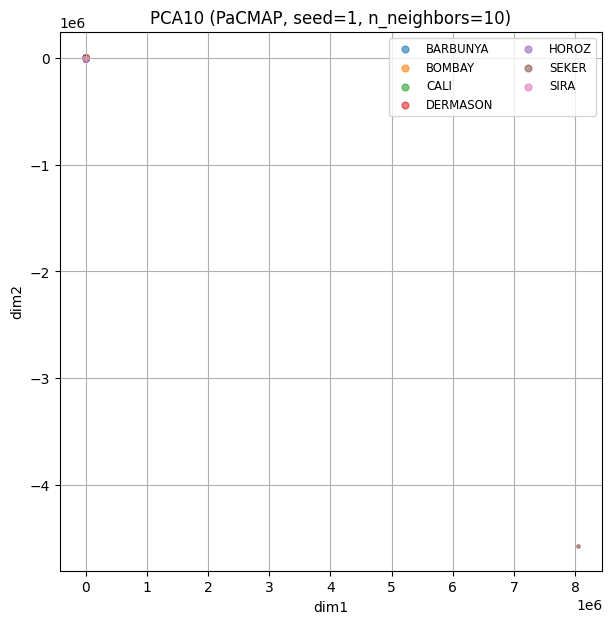


=== (2) Нелинейные методы ПОСЛЕ PCA ===

Форма данных после PCA → (13611, 3)


/Users/andrejtiskin/Develop/Study/StatisticalDecisionTheory/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import pacmap


def scatter_embedding(Z, y, title):
    plt.figure(figsize=(7, 7))
    for cls in np.unique(y):
        idx = (y == cls)
        plt.scatter(Z[idx, 0], Z[idx, 1], s=6, alpha=0.6, label=str(cls))
    plt.title(title)
    plt.xlabel("dim1")
    plt.ylabel("dim2")
    plt.legend(markerscale=2, fontsize='small', ncol=2)
    plt.grid(True)
    plt.show()


def run_pacmap_with_safe_neighbors(X_for_emb, y, seed, title, base_n_neighbors=10, n_components=2):
    """
    PaCMAP с n_neighbors ограничиваем так чтобы Annoy не сходил с ума.
    """
    n_samples = X_for_emb.shape[0]
    # ровно твоя логика:
    max_nn = max(1, n_samples - 51)
    nn_pac = min(base_n_neighbors, max_nn)

    embedding = pacmap.PaCMAP(
        n_components=n_components,
        n_neighbors=nn_pac,
        random_state=seed
    )

    X_noisy = X_for_emb + np.random.normal(scale=1e-6, size=X_for_emb.shape)

    Z = embedding.fit_transform(
        X_noisy,
        init='random'
    )
    scatter_embedding(Z, y, f"{title} (PaCMAP, seed={seed}, n_neighbors={nn_pac})")


print("=== ПУНКТ 11: Нелинейные методы ===\n")


pca10 = PCA(n_components=10)
X_for_pacmap = pca10.fit_transform(X_k_scaled)
print("Форма данных для PaCMAP (PCA10):", X_for_pacmap.shape)


print("\n=== (1) Нелинейные методы БЕЗ PCA ===\n")

for seed in [0, 1]:
    # UMAP
    Z_umap = umap.UMAP(
        n_components=2,
        n_neighbors=15,
        init='random',
        random_state=seed
    ).fit_transform(X_k_scaled)
    scatter_embedding(Z_umap, y_k, f"UMAP (seed={seed}, без PCA)")

    # t-SNE
    Z_tsne = TSNE(
        n_components=2,
        init='random',
        random_state=seed,
        learning_rate='auto'
    ).fit_transform(X_k_scaled)
    scatter_embedding(Z_tsne, y_k, f"t-SNE (seed={seed}, без PCA)")

    # PaCMAP ровно с твоей логикой nn_pac
    run_pacmap_with_safe_neighbors(
        X_for_emb=X_for_pacmap,
        y=y_k,
        seed=seed,
        title="PCA10"
    )

X_k_pca_reduced = X_k_pca[:, :n_keep]
print("\n=== (2) Нелинейные методы ПОСЛЕ PCA ===\n")
print("Форма данных после PCA →", X_k_pca_reduced.shape)

for seed in [0, 1]:
    # UMAP
    Z_umap_p = umap.UMAP(
        n_components=2,
        n_neighbors=15,
        init='random',
        random_state=seed
    ).fit_transform(X_k_pca_reduced)
    scatter_embedding(Z_umap_p, y_k,
                      f"UMAP (seed={seed}, после PCA → {n_keep}D)")

    # t-SNE
    Z_tsne_p = TSNE(
        n_components=2,
        init='random',
        random_state=seed,
        learning_rate='auto'
    ).fit_transform(X_k_pca_reduced)
    scatter_embedding(Z_tsne_p, y_k,
                      f"t-SNE (seed={seed}, после PCA → {n_keep}D)")

    # PaCMAP с той же безопасной логикой
    run_pacmap_with_safe_neighbors(
        X_for_emb=X_k_pca_reduced,
        y=y_k,
        seed=seed,
        title=f"PCA→{n_keep}D"
    )